# Comparative Evaluation of Deep Archetypal Analysis Frameworks



**Group 124**: João Mata (S251710), Manuel Charneca (S253708), Georgios Alexiadis (S253130)

This notebook reproduces the main results from our comparative study of Linear Archetypal Analysis and AAnet on MNIST and single-cell RNA-seq datasets.

## Table of Contents
0. Setup and Imports
1. MNIST Dataset Analysis
   - 1.1 Linear AA on MNIST
   - 1.2 AAnet on MNIST
2. Single-Cell RNA Dataset Analysis
   - 2.1 Linear AA on Single-Cell Data
   - 2.2 AAnet on Single-Cell Data

# 0. Setup and Imports

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm
from scipy.spatial.distance import squareform, pdist
from itertools import combinations
import os
import sys
import warnings
import umap
import scanpy as sc
import scprep
import magic
import sklearn
from sklearn import decomposition
import phate

# From the LINEAR AA implementation
from src.methods.AALS import AALS
from src.methods.AABernoulli import Bernoulli_Archetypal_Analysis

# From the AAnet implementation
from AAnet_torch import *
from AAnet_torch import models, utils, data, plot
from torch import optim


# PART 1.1: Linear AA on MNIST

In [ ]:

N_ARCHETYPES = 3
N_RUNS = 5
SAVE_DIR = 'results/MNIST_5runs'
os.makedirs(SAVE_DIR, exist_ok=True)

## Load MNIST data

In [ ]:

# 1. Load and Preprocess MNIST (The "Binary" way)
print("Loading MNIST...")
transform = transforms.Compose([transforms.ToTensor(), transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_all = mnist.data.numpy()
data_all = data_all / 255
data_all = (data_all * 2) - 1 # norm
labels = mnist.targets.numpy()

print("MNIST Loaded. Data shape:", data_all.shape)

Loading MNIST...
MNIST Loaded. Data shape: (60000, 28, 28)


In [ ]:

# Pick single digitw
digit = 4

# Select data for the specified digit
idx_digit = mnist.targets.numpy() == digit

# Create dataset for the selected digit
data_digit = data_all[idx_digit,]

# Reshape data to 2D array (samples x features)
data_digit = np.reshape(data_digit, (data_digit.shape[0], -1))

# Print shape of the digit-specific dataset
print(data_digit.shape)

# Added a transposoition to ensure final shape
X = torch.tensor(data_digit, dtype=torch.float64).transpose(0, 1)

(5842, 784)


## Gaussian Method

In [ ]:
S_list = []
C_list = []
L_list = []  # <-- store the losses

for run in range(N_RUNS):
    print(f"Run {run+1}/{N_RUNS}")
    
    C_run, S_run, L_run, EV = AALS(X, N_ARCHETYPES)  # Your Linear AA function
    
    # Append to lists
    S_list.append(S_run.detach().cpu().numpy() if isinstance(S_run, torch.Tensor) else S_run)
    C_list.append(C_run.detach().cpu().numpy() if isinstance(C_run, torch.Tensor) else C_run)
    L_list.append(L_run)

# Save everything
torch.save({'C': C_list, 'S': S_list, 'L': L_list}, os.path.join(SAVE_DIR, 'mnist_gaussian_aa_results.pth'))


Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


## Visualize the results

In [ ]:
# Open the saved results to verify
results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/LinearAA/Python/results/MNIST_5runs/mnist_gaussian_aa_results.pth', weights_only=False)
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C'][0].shape)
print("Shape of S in first run:", results['S'][0].shape)
print("Length of Losses in first run:", len(results['L'][0]))

Saved Results Keys: dict_keys(['C', 'S', 'L'])
Number of Runs Saved: 5
Shape of C in first run: (5842, 3)
Shape of S in first run: (3, 5842)
Length of Losses in first run: 23


## Calculating Metrics

In [ ]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [ ]:
from itertools import combinations

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C']]
print("C_matrices length:", len(C_matrices))
S_matrices = [to_numpy(S) for S in results['S']]
print("C_matrices length:", len(C_matrices))
X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Linear AA 5-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 5
C_matrices length: 5
---
Linear AA 5-run stability:
---
Mean NMI: 0.999173054583444
Mean Archetype Consistency: 0.9999994208568423
Mean ISI: 0.01230146085008011


## Analysing the Archetypes

In [ ]:
# Select archetypes to visualize from the loaded results
C_linear = results['C'][0]
S_linear = results['S'][0]

print("C_linear shape:", C_linear.shape)
print("S_linear shape:", S_linear.shape)

C_linear shape: (5842, 3)
S_linear shape: (3, 5842)


## Visualizing the Archetypes

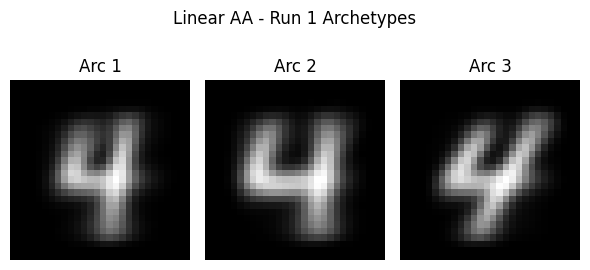

In [ ]:
def to_numpy(tensor):
    """Convert tensor to numpy array if needed."""
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def plot_archetypes(C, img_shape=(28,28), title="Archetypes"):
    # C is (features × archetypes)
    C = to_numpy(C)
    n_archetypes = C.shape[1]
    
    fig, axes = plt.subplots(1, n_archetypes, figsize=(2*n_archetypes, 3))
    for i in range(n_archetypes):
        img = C[:, i].reshape(img_shape)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Arc {i+1}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Transpose X_raw to (samples, features)
X_samples = X_raw.T 

# Reconstruct archetypes (features × archetypes)
C_recon = X_samples.T @ S_matrices[0].T  # (784, 3)

plot_archetypes(C_recon, img_shape=(28,28), title="Linear AA - Run 1 Archetypes")



/opt/anaconda3/envs/sae_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


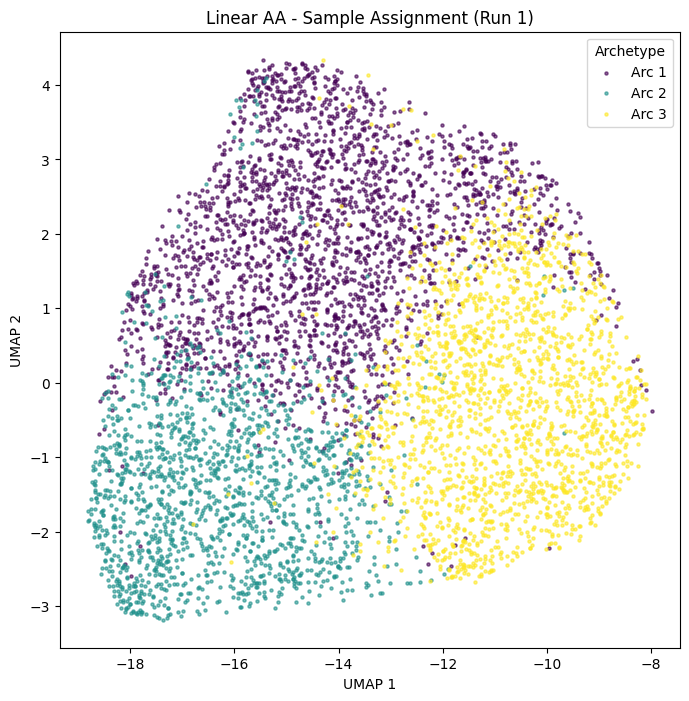

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import umap

def plot_umap_assignment(X, S, title="Sample Assignment", s=5, alpha=0.6, cmap='viridis'):
    # Convert S to numpy if tensor
    S = to_numpy(S)
    X = to_numpy(X)

    # Step 1: compute dominant archetype for each sample
    dominant_arc = np.argmax(S, axis=0)  # shape: (N_samples,)

    # Step 2: reduce X to 2D using UMAP
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
    X_embedded = reducer.fit_transform(X)  # shape: (N_samples, 2)

    # Step 3: scatter plot colored by dominant archetype
    n_archetypes = S.shape[0]
    plt.figure(figsize=(8,8))

    # Get the colormap
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, n_archetypes))

    # Plot each archetype separately to create a legend
    for i in range(n_archetypes):
        plt.scatter(
            X_embedded[dominant_arc==i, 0],
            X_embedded[dominant_arc==i, 1],
            color=colors[i],
            s=s,
            alpha=alpha,
            label=f"Arc {i+1}"
        )

    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Archetype")
    plt.show()

# Example usage:
plot_umap_assignment(X_samples, S_matrices[0], title="Linear AA - Sample Assignment (Run 1)")



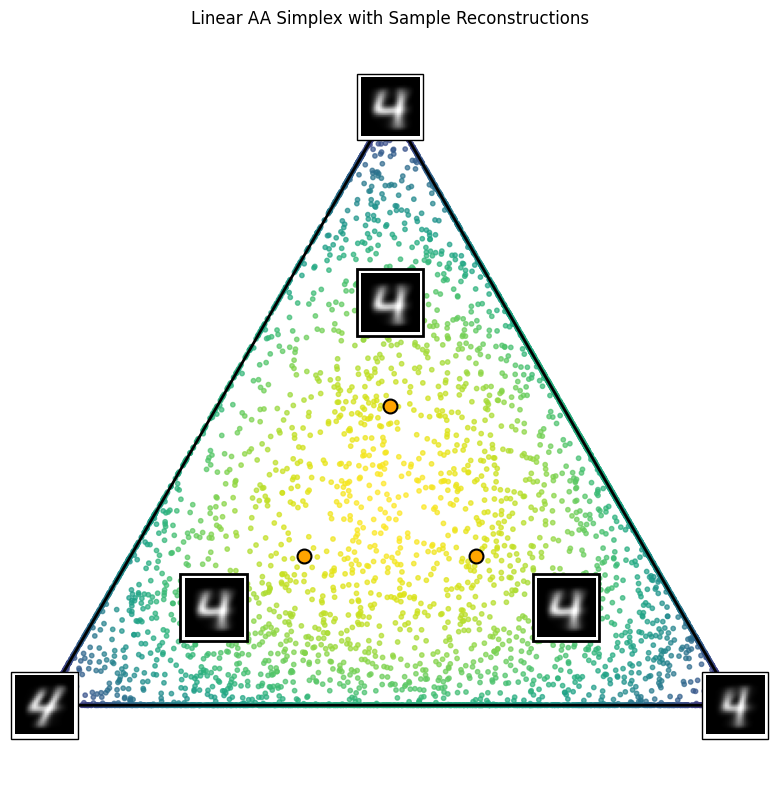

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import entropy

def plot_simplex_with_samples(S, C=None, title="Simplex Plot", s=10, cmap='viridis', 
                               show_archetypes=True, sample_points=None, img_shape=(28, 28),
                               zoom=1.5):
    S = np.array(S)
    k, N = S.shape
    if k != 3:
        raise ValueError("Simplex plot only works for k=3 archetypes")
    
    # Auto-detect and fix C orientation
    if C is not None:
        C = np.array(C)
        if C.shape[0] == 3 and C.shape[1] != 3:
            C = C.T
        elif C.shape[0] != np.prod(img_shape):
            print(f"Warning: C shape {C.shape} may not match img_shape {img_shape}")
    
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    X_simplex = S.T @ vertices  # shape: (N, 2)
    
    mix_strength = np.array([entropy(S[:, i]) for i in range(N)])
    mix_strength /= np.log(3)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(X_simplex[:, 0], X_simplex[:, 1], c=mix_strength, 
                cmap=cmap, s=s, alpha=0.7)
    triangle = Polygon(vertices, fill=False, linewidth=2)
    plt.gca().add_patch(triangle)
    
    if show_archetypes and C is not None:
        for i in range(3):
            img = C[:, i].reshape(img_shape)
            im_box = OffsetImage(img, zoom=zoom, cmap='gray')
            ab = AnnotationBbox(im_box, vertices[i], frameon=True, pad=0.3)
            plt.gca().add_artist(ab)
    
    if sample_points is not None and C is not None:
        for weights in sample_points:
            weights = np.array(weights)
            weights = weights / weights.sum()
            pos_2d = weights @ vertices
            reconstructed = C @ weights
            img = reconstructed.reshape(img_shape)
            plt.scatter(pos_2d[0], pos_2d[1], c='orange', s=100, 
                       marker='o', edgecolors='black', linewidths=1.5, zorder=10)
            offset = pos_2d - np.array([0.5, np.sqrt(3)/6])
            offset = offset / np.linalg.norm(offset) * 0.15
            ab = AnnotationBbox(im_box, pos_2d + offset, frameon=True, 
                               pad=0.3, bboxprops=dict(linewidth=2))
            plt.gca().add_artist(ab)
    
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example barycentric sample points
sample_points = [
    (0.1, 0.05, 0.05),  # Near archetype 0
    (0.05, 0.1, 0.05),  # Near archetype 1
    (0.05, 0.05, 0.1)   # Near archetype 2
]

plot_simplex_with_samples(S_matrices[0], C=C_recon, 
                          title="Linear AA Simplex with Sample Reconstructions",
                          sample_points=sample_points)



In [ ]:
import numpy as np

# Choose sample indices once
n_samples = 5
np.random.seed(42)  # for reproducibility
selected_indices = np.random.choice(X_samples.shape[0], n_samples, replace=False)
print("Selected sample indices for visualization:", selected_indices)
# Save these indices to reuse in other notebooks
np.save("selected_indices.npy", selected_indices)


Selected sample indices for visualization: [4584  177  167 5585 2339]


## Calculating the reconstructions

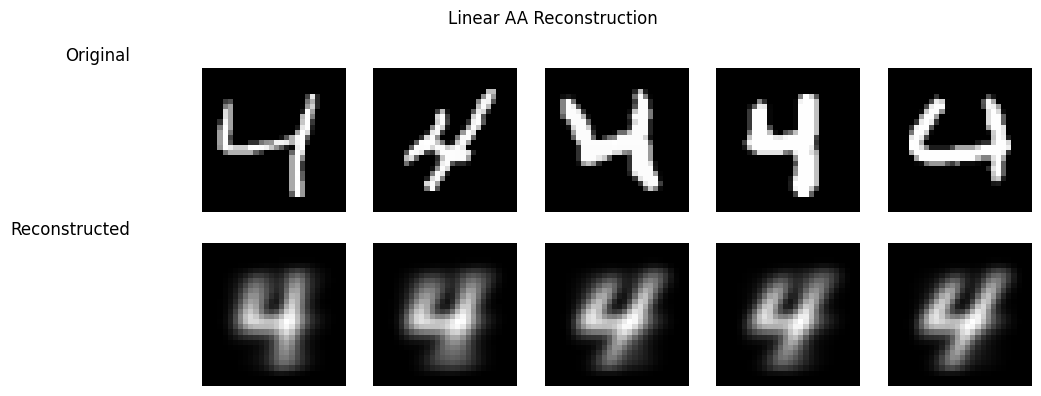

In [ ]:
def plot_reconstruction_flat(X_orig, X_recon, n_samples=5, img_shape=(28,28), title="Reconstruction"):
    """
    Visualize original samples and their reconstructions for given indices.

    X_orig: (samples, features)
    X_recon: (samples, features)
    n_samples: number of samples to show (default 5)
    img_shape: shape to reshape each sample (default (28,28))
    title: plot title
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(2*n_samples, 4))

    for i in range(n_samples):
        idx = i
        # Original
        axes[0, i].imshow(X_orig[idx].reshape(img_shape), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Original", x=-0.5, ha='right')

        # Reconstructed without clipping
        rec = X_recon[idx].reshape(img_shape)
        axes[1, i].imshow(rec, cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Reconstructed", x=-0.5, ha='right')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Make sure X_raw is (samples, features)
X_samples = X_raw.T  # shape: (5842, 784)
C_recon = X_samples.T @ S_matrices[0].T  # (784, k)

# Reconstruct samples
X_rec = (C_recon @ S_matrices[0]).T 

import numpy as np

# save the reconstructions
import numpy as np
np.save("X_rec_LINEAR.npy", X_rec)
np.save("X_samples.npy", X_samples)

selected_indices = np.load("selected_indices.npy")

from scipy.stats import entropy

# Calculate how "mixed" each sample is
mix_strength = np.array([entropy(S_matrices[0][:, i]) for i in range(S_matrices[0].shape[1])])
mix_strength /= np.log(N_ARCHETYPES)  # normalize

# Show samples with low mixing (close to pure archetypes)
pure_samples = [0, 1, 2, 5, 6, 13, 18, 20, 22, 30]

# For Linear AA reconstruction plotting
plot_reconstruction_flat(X_samples[pure_samples], X_rec[selected_indices],
                         n_samples=len(selected_indices), title="Linear AA Reconstruction")




In [ ]:
import numpy as np
import torch

def to_numpy(x):
    return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)

def normalize_S(S, N):
    """Ensure S has shape (K, N)."""
    S = to_numpy(S)
    if S.shape[1] == N:
        return S             # already (K, N)
    if S.shape[0] == N:
        return S.T           # was (N, K)
    raise ValueError(f"Cannot reshape S. Got {S.shape}, expected (K,N) or (N,K).")

def compute_C_from_S(X_raw, S):
    """C = X Sᵀ (S Sᵀ)^(-1). Produces (D, K)."""
    SST = S @ S.T
    return X_raw @ S.T @ np.linalg.pinv(SST)

def reconstruct(X_raw, C_saved, S_saved):
    """
    Reconstruct X using saved S and (maybe) saved C.
    Returns X_rec (N,D), C_features (D,K), S_kxn (K,N).
    """
    X_raw = to_numpy(X_raw)        # (D, N)
    D, N = X_raw.shape

    S = normalize_S(S_saved, N)    # (K, N)
    K = S.shape[0]

    C_saved = to_numpy(C_saved)

    # If C is not (D,K), recompute from X and S
    if C_saved.shape != (D, K):
        C_feat = compute_C_from_S(X_raw, S)
    else:
        C_feat = C_saved

    # Reconstruction: (D,K)(K,N) = (D,N) → transpose → (N,D)
    X_rec = (C_feat @ S).T
    return X_rec, C_feat, S

def mse_metrics(X_true, X_rec):
    X_true = np.asarray(X_true)
    X_rec  = np.asarray(X_rec)

    N, D = X_true.shape
    residuals = X_true - X_rec

    SSE = np.sum(residuals**2)
    MSE = SSE / (N * D)
    RMSE = np.sqrt(MSE)

    mean_x = X_true.mean(axis=0)
    SST = np.sum((X_true - mean_x)**2)
    R2 = 1 - SSE/SST if SST > 0 else np.nan

    return dict(MSE=MSE, RMSE=RMSE, R2=R2)


In [ ]:
# Calculate average reconstruction metrics across all runs for Linear AA

all_metrics = []
for i in range(N_RUNS):
    # Reconstruct for each run
    X_rec_i, _, _ = reconstruct(X_samples.T, results['C'][i], results['S'][i])
    metrics_i = mse_metrics(X_samples, X_rec_i)
    all_metrics.append(metrics_i)

# Compute averages
avg_metrics = {
    'MSE': np.mean([m['MSE'] for m in all_metrics]),
    'RMSE': np.mean([m['RMSE'] for m in all_metrics]),
    'R2': np.mean([m['R2'] for m in all_metrics])
}

print("LINEAR AA on MNIST\nAverage Reconstruction Metrics (across all runs):", avg_metrics)

LINEAR AA on MNIST
Average Reconstruction Metrics (across all runs): {'MSE': 0.16643856342691965, 'RMSE': 0.4079688265286926, 'R2': 0.2018570305770142}


# PART 1.2: Deep AA (AANET) on MNIST

In [ ]:
N_ARCHETYPES = 3
N_RUNS = 3
N_EPOCHS = 10 
N_PROTOTYPES = 10     

#SAVE_DIR = 'results/MNIST_AANET_1run50epochs'
#SAVE_DIR = 'results/MNIST_5runs'
SAVE_DIR = 'results/MNIST_10epochs'

os.makedirs(SAVE_DIR, exist_ok=True)

data_loader = torch.utils.data.DataLoader(data_digit, batch_size=256, shuffle=True, num_workers=4)

# Added a transposoition to ensure final shape
X = torch.tensor(data_digit, dtype=torch.float64).transpose(0, 1)

# Warm-start model with graph-based extrema for improved results
extrema = torch.Tensor(utils.get_laplacian_extrema(data_digit, n_extrema=N_ARCHETYPES))
extrema = torch.Tensor(data_digit[extrema.numpy().astype(int)])



In [ ]:
device = torch.device('cpu')

### Run AAnet

In [ ]:
from tqdm import trange
import torch
import numpy as np
import os

S_list = []
C_list = []
loss_history = []  # Track loss per run
metrics_history = []  # Track metrics at checkpoints

# Define checkpoints to evaluate
CHECKPOINTS = [1, 3, 5, 7, 10]  # Epochs to compute metrics

# Storage for checkpoint results
checkpoint_results = {ep: {'S_list': [], 'C_list': []} for ep in CHECKPOINTS}

for run in range(N_RUNS):
    print(f"\n{'='*50}")
    print(f"Run {run+1}/{N_RUNS}")
    print(f"{'='*50}")
    
    # Reset model for each run (important!)
    model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                                  n_archetypes=N_ARCHETYPES, 
                                  input_shape=data_digit.shape[1],
                                  device=device, diffusion_extrema=None)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    run_losses = []
    
    # Train for N_EPOCHS with progress bar
    for epoch in trange(1, N_EPOCHS + 1, desc=f"Training Run {run+1}", leave=True):
        loss, r_loss, a_loss = utils.train_epoch(model, data_loader, optimizer, 
                                                   epoch=epoch, gamma_extrema=1.0)
        run_losses.append(loss)
        
        # Print loss every few epochs
        if epoch % 2 == 0 or epoch == 1:
            print(f"  Epoch {epoch:2d} | Loss: {loss:.6f} | R_loss: {r_loss:.6f} | A_loss: {a_loss:.6f}")
        
        # Save embeddings at checkpoints
        if epoch in CHECKPOINTS:
            archetypal_embedding = model.encode(torch.Tensor(data_digit)).detach().numpy()
            barycentric_embedding = model.euclidean_to_barycentric(
                torch.Tensor(archetypal_embedding)).detach().numpy()
            
            S_T = barycentric_embedding.T
            C = S_T.T
            
            checkpoint_results[epoch]['S_list'].append(S_T)
            checkpoint_results[epoch]['C_list'].append(C)
    
    # Store loss history
    loss_history.append(run_losses)
    
    # Encode final embeddings (epoch 10)
    archetypal_embedding = model.encode(torch.Tensor(data_digit)).detach().numpy()
    barycentric_embedding = model.euclidean_to_barycentric(
        torch.Tensor(archetypal_embedding)).detach().numpy()
    
    S_T = barycentric_embedding.T
    C = S_T.T
    
    # Save final run results
    S_list.append(S_T)
    C_list.append(C)
    
    print(f"\n✓ Run {run+1} complete - S shape: {S_T.shape}, C shape: {C.shape}")
    
    # Optional: save per run
    np.savez(os.path.join(SAVE_DIR, f'run{run+1}_results.npz'), 
             S=S_T, C=C, X=data_digit, losses=run_losses)

# Save all runs together
torch.save({
    'S_list': S_list, 
    'C_list': C_list, 
    'X': data_digit,
    'loss_history': loss_history,
    'checkpoint_results': checkpoint_results
}, os.path.join(SAVE_DIR, 'mnist_aanet_aa_results.pth'))

# Save the model state dict of the last run
torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'mnist_aanet_model_last_run.pth'))

print(f"\n{'='*50}")
print(f"✅ Saved all {N_RUNS} runs results.")
print(f"{'='*50}")

### Visualize the training

In [ ]:

# =========================================
# VISUALIZE TRAINING PROGRESS
# =========================================

print("\n📊 Plotting training curves...")

# 1. Plot Loss Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, losses in enumerate(loss_history):
    plt.plot(range(1, len(losses) + 1), losses, marker='o', label=f'Run {i+1}', alpha=0.7)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Plot Average Loss ± Std
plt.subplot(1, 2, 2)
loss_array = np.array(loss_history)
mean_loss = loss_array.mean(axis=0)
std_loss = loss_array.std(axis=0)
epochs = np.arange(1, N_EPOCHS + 1)

plt.plot(epochs, mean_loss, marker='o', linewidth=2, color='blue', label='Mean Loss')
plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, 
                 alpha=0.3, color='blue', label='±1 Std')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Mean Training Loss Across Runs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_loss_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print the final loss
print(f"Final Loss after {N_EPOCHS} epochs:")
for i, losses in enumerate(loss_history):
    print(f"  Run {i+1}: {losses[-1]:.6f}")


## Visualize the Results

In [ ]:
# Open the saved results to verify

results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/MNIST_10epochs/mnist_aanet_aa_results.pth', weights_only=False)
#results = torch.load("/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/MNIST_AANET_71runs/mnist_aanet_aa_results.pth", weights_only=False)
#results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/MNIST_AANET_1run50epochs/mnist_aanet_aa_results.pth', weights_only=False)

# load from the new SAVE_DIR
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C_list']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C_list'][0].shape)
print("Shape of S in first run:", results['S_list'][0].shape)
print('Shape of X in first run:', results['X'].shape)

Saved Results Keys: dict_keys(['S_list', 'C_list', 'X', 'loss_history', 'checkpoint_results'])
Number of Runs Saved: 3
Shape of C in first run: (5842, 3)
Shape of S in first run: (3, 5842)
Shape of X in first run: (5842, 784)


## Calculating the Metrics

In [ ]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [ ]:
from itertools import combinations

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C_list']]
print("C_matrices length:", len(C_matrices))
print("C_matrices[0] shape:", C_matrices[0].shape)
S_matrices = [to_numpy(S) for S in results['S_list']]
print("S_matrices length:", len(S_matrices))
print("S_matrices[0] shape:", S_matrices[0].shape)

X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Deep AANET AA 3-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 3
C_matrices[0] shape: (5842, 3)
S_matrices length: 3
S_matrices[0] shape: (3, 5842)
---
Deep AANET AA 3-run stability:
---
Mean NMI: 0.8370934184284081
Mean Archetype Consistency: 0.8325935158003405
Mean ISI: 0.5334680895856398


## Analysing the Archetypes

In [ ]:
# Select archetypes to visualize from the loaded results
C_aanet = results['C_list'][0]
S_aanet = results['S_list'][0]

print("C_aanet shape:", C_aanet.shape)
print("S_aanet shape:", S_aanet.shape)

C_aanet shape: (5842, 3)
S_aanet shape: (3, 5842)


## Visualizing the Archetypes

In [ ]:
def plot_decoded_archetypes(model, img_shape=(28, 28), title="Decoded Archetypes"):
    """
    Decode and visualize archetypes from a trained AANET model.

    Parameters
    ----------
    model : AAnet_vanilla
        Trained AANET model.
    img_shape : tuple, default=(28,28)
        Shape to reshape the decoded archetypes.
    title : str
        Title for the plot.
    """
    model.eval()  # set to evaluation mode

    # 1. Get latent-space coordinates of archetypes
    if hasattr(model, 'archetypal_simplex'):
        z_archetypes = model.archetypal_simplex  # shape: [K, latent_dim]
    else:
        raise ValueError("Model has no attribute 'archetypal_simplex'.")

    # 2. Decode to pixel space
    with torch.no_grad():
        decoded_archetypes = model.decode(z_archetypes)  # shape: [K, D]

    # 3. Convert to numpy and transpose for plotting (D × K)
    C_recon = decoded_archetypes.cpu().numpy().T  # shape: (D, K)
    K = C_recon.shape[1]

    # 4. Plot
    fig, axes = plt.subplots(1, K, figsize=(3*K, 3))
    for i in range(K):
        axes[i].imshow(C_recon[:, i].reshape(img_shape), cmap="gray")
        axes[i].set_title(f"Archetype {i+1}")
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()

plot_decoded_archetypes(model, img_shape=(28, 28), title="Decoded Archetypes from AANET Model")

In [ ]:
# Make sure your model is in eval mode
model.eval()

# Get latent simplex corners for n_archetypes
z_archetypes = model.get_n_simplex(n=N_ARCHETYPES).to(model.device)

# Decode them through the non-linear decoder
with torch.no_grad():
    C_decoded = model.decode(z_archetypes)  # shape: (n_archetypes, D)

C_decoded = C_decoded.cpu().numpy()  # convert to numpy for plotting


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


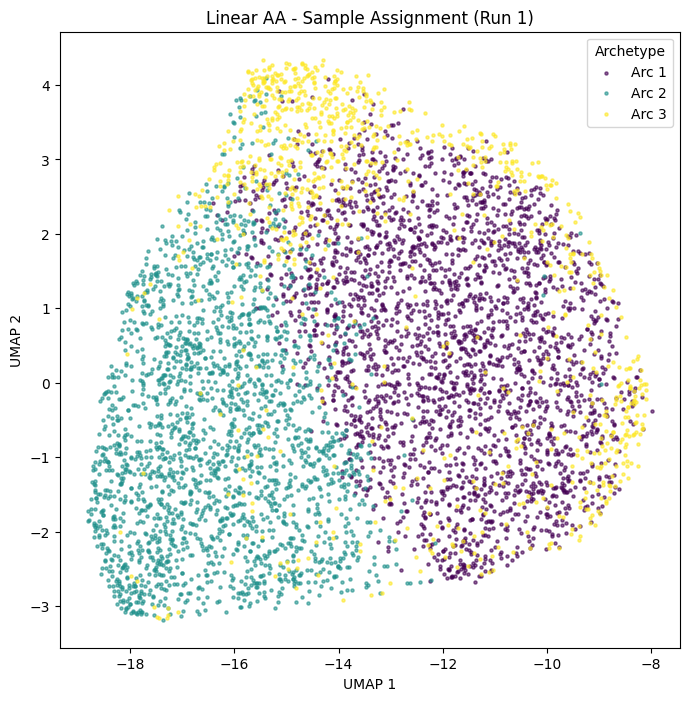

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import umap

def plot_umap_assignment(X, S, title="Sample Assignment", s=5, alpha=0.6, cmap='viridis'):
    # Convert S to numpy if tensor
    S = to_numpy(S)
    X = to_numpy(X)

    # Step 1: compute dominant archetype for each sample
    dominant_arc = np.argmax(S, axis=0)  # shape: (N_samples,)

    # Step 2: reduce X to 2D using UMAP
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
    X_embedded = reducer.fit_transform(X)  # shape: (N_samples, 2)

    # Step 3: scatter plot colored by dominant archetype
    n_archetypes = S.shape[0]
    plt.figure(figsize=(8,8))

    # Get the colormap
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, n_archetypes))

    # Plot each archetype separately to create a legend
    for i in range(n_archetypes):
        plt.scatter(
            X_embedded[dominant_arc==i, 0],
            X_embedded[dominant_arc==i, 1],
            color=colors[i],
            s=s,
            alpha=alpha,
            label=f"Arc {i+1}"
        )

    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Archetype")
    plt.show()


# Linear AA: S_matrices[0] shape (k × N_samples)
plot_umap_assignment(X_raw.T, S_matrices[0], title="Linear AA - Sample Assignment (Run 1)")


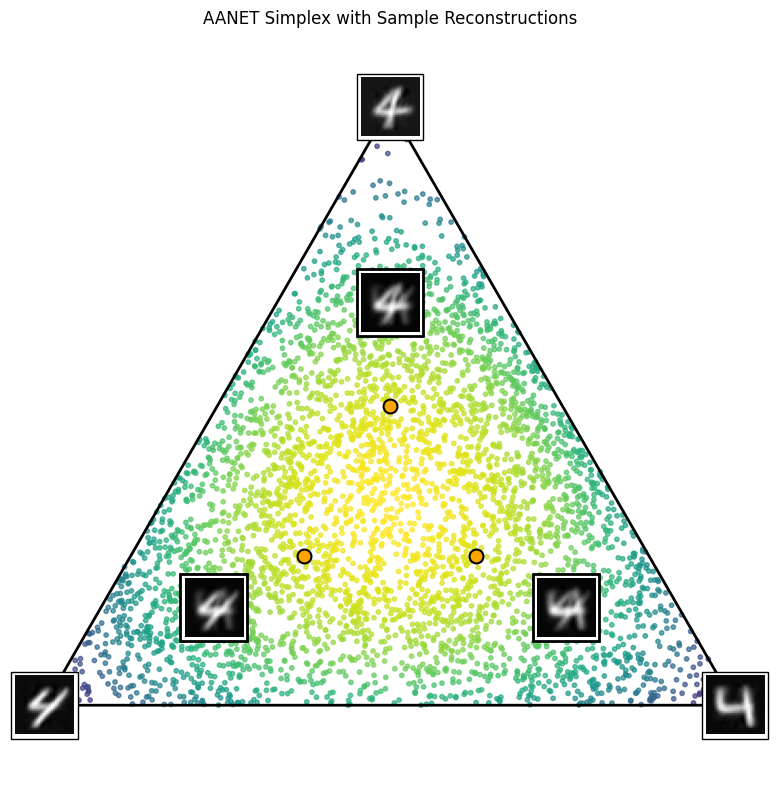

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import entropy

def plot_simplex_with_samples(S, C=None, title="Simplex Plot", s=10, cmap='viridis', 
                               show_archetypes=True, sample_points=None, img_shape=(28, 28),
                               zoom=1.5):
    """
    Plot simplex with sample reconstructions at specific barycentric coordinates.
    
    Parameters:
    -----------
    S : array, shape (k, N)
        Simplex coordinates (archetype weights) for N samples
    C : array, shape (d, k) or (k, d)
        Archetype matrix - will be auto-detected and transposed if needed
    sample_points : list of tuples, optional
        List of barycentric coordinates (w1, w2, w3) where sum=1
        E.g., [(0.5, 0.3, 0.2), (0.33, 0.33, 0.34)]
    img_shape : tuple
        Shape to reshape features for display (height, width)
    zoom : float
        Zoom level for displayed images
    """
    S = np.array(S)
    k, N = S.shape
    if k != 3:
        raise ValueError("Simplex plot only works for k=3 archetypes")
    
    # Auto-detect and fix C orientation
    if C is not None:
        C = np.array(C)
        if C.shape[0] == 3 and C.shape[1] != 3:
            # C is (3, d), need (d, 3)
            C = C.T
        elif C.shape[0] != np.prod(img_shape):
            print(f"Warning: C shape {C.shape} may not match img_shape {img_shape}")
    
    # Barycentric coordinates -> 2D triangle coordinates
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    X_simplex = S.T @ vertices  # shape: (N, 2)
    
    # Compute mixing strength (entropy)
    mix_strength = np.array([entropy(S[:, i]) for i in range(N)])
    mix_strength /= np.log(3)  # normalize between 0 and 1
    
    # Create plot
    plt.figure(figsize=(8, 8))
    
    # Plot all samples
    plt.scatter(X_simplex[:, 0], X_simplex[:, 1], c=mix_strength, 
                cmap=cmap, s=s, alpha=0.7)
    
    # Draw triangle edges
    triangle = Polygon(vertices, fill=False, linewidth=2)
    plt.gca().add_patch(triangle)
    
    # Plot archetypes at corners
    if show_archetypes and C is not None:
        for i in range(3):
            img = C[:, i].reshape(img_shape)
            im_box = OffsetImage(img, zoom=zoom, cmap='gray')
            ab = AnnotationBbox(im_box, vertices[i], frameon=True, pad=0.3)
            plt.gca().add_artist(ab)
    
    # Plot sample reconstructions at specified points
    if sample_points is not None and C is not None:
        for weights in sample_points:
            weights = np.array(weights)
            # Ensure weights sum to 1
            weights = weights / weights.sum()
            
            # Compute 2D position in triangle
            pos_2d = weights @ vertices
            
            # Reconstruct image: X_reconstructed = C @ weights
            reconstructed = C @ weights
            img = reconstructed.reshape(img_shape)
            
            # Mark the point
            plt.scatter(pos_2d[0], pos_2d[1], c='orange', s=100, 
                       marker='o', edgecolors='black', linewidths=1.5, zorder=10)
            
            # Display reconstructed image near the point
            im_box = OffsetImage(img, zoom=zoom, cmap='gray')
            # Offset the image slightly outward from center for better visibility
            offset = pos_2d - np.array([0.5, np.sqrt(3)/6])
            offset = offset / np.linalg.norm(offset) * 0.15
            ab = AnnotationBbox(im_box, pos_2d + offset, frameon=True, 
                               pad=0.3, bboxprops=dict(linewidth=2))
            plt.gca().add_artist(ab)
    
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Example usage:
# Select points in barycentric coordinates (must sum to 1)
# Place sample points equally distanced to each corner of the simplex
sample_points = [
    (0.1, 0.05, 0.05),  # Near archetype 0
    (0.05, 0.1, 0.05),  # Near archetype 1
    (0.05, 0.05, 0.1)   # Near archetype 2
]

plot_simplex_with_samples(S_list[0], C=C_decoded.T, 
                          title="AANET Simplex with Sample Reconstructions",
                          sample_points=sample_points)

## Calculating the reconstructions

In [ ]:


def normalize_S(S, N):
    """Ensure S has shape (K, N)."""
    S = to_numpy(S)
    if S.shape[1] == N:
        return S             # already (K, N)
    if S.shape[0] == N:
        return S.T           # was (N, K)
    raise ValueError(f"Cannot reshape S. Got {S.shape}, expected (K,N) or (N,K).")

def compute_C_from_S(X_raw, S):
    """C = X Sᵀ (S Sᵀ)^(-1). Produces (D, K)."""
    SST = S @ S.T
    return X_raw @ S.T @ np.linalg.pinv(SST)

def reconstruct(X_raw, C_saved, S_saved):
    """
    Reconstruct X using saved S and (maybe) saved C.
    Returns X_rec (N,D), C_features (D,K), S_kxn (K,N).
    """
    X_raw = to_numpy(X_raw)        # (D, N)
    D, N = X_raw.shape

    S = normalize_S(S_saved, N)    # (K, N)
    K = S.shape[0]

    C_saved = to_numpy(C_saved)

    # If C is not (D,K), recompute from X and S
    if C_saved.shape != (D, K):
        C_feat = compute_C_from_S(X_raw, S)
    else:
        C_feat = C_saved

    # Reconstruction: (D,K)(K,N) = (D,N) → transpose → (N,D)
    X_rec = (C_feat @ S).T
    return X_rec, C_feat, S

def mse_metrics(X_true, X_rec):
    X_true = np.asarray(X_true)
    X_rec  = np.asarray(X_rec)

    N, D = X_true.shape
    residuals = X_true - X_rec

    SSE = np.sum(residuals**2)
    MSE = SSE / (N * D)
    RMSE = np.sqrt(MSE)

    mean_x = X_true.mean(axis=0)
    SST = np.sum((X_true - mean_x)**2)
    R2 = 1 - SSE/SST if SST > 0 else np.nan

    return dict(MSE=MSE, RMSE=RMSE, R2=R2)



In [ ]:
with torch.no_grad():
    X_tensor = torch.tensor(X_samples, dtype=torch.float32).to(device)   # N × 784
    Z = model.encode(X_tensor)                                           # N × latent_dim
    X_rec_AANET = model.decode(Z).cpu().numpy()                           # N × 784

# Evaluate reconstruction metrics
metrics_aanet = mse_metrics(X_samples, X_rec_AANET)
print("AANET Reconstruction Metrics:", metrics_aanet)


AANET Reconstruction Metrics: {'MSE': 0.1255284231868203, 'RMSE': 0.3542999057109955, 'R2': 0.3980383730402388}


## Analysing each checkpoint in the training

In [ ]:
results.keys()
# print checkpoint results keys
checkpoint_results = results['checkpoint_results']
print("Checkpoint Results Keys:", checkpoint_results.keys())
# print the inside of each checkpoint
for ep in checkpoint_results:
    print(f" Epoch {ep} Keys:", checkpoint_results[ep].keys())
    

Checkpoint Results Keys: dict_keys([1, 3, 5, 7, 10])
 Epoch 1 Keys: dict_keys(['S_list', 'C_list'])
 Epoch 3 Keys: dict_keys(['S_list', 'C_list'])
 Epoch 5 Keys: dict_keys(['S_list', 'C_list'])
 Epoch 7 Keys: dict_keys(['S_list', 'C_list'])
 Epoch 10 Keys: dict_keys(['S_list', 'C_list'])



📈 Computing metrics at checkpoints (per run)...

📊 Plotting metrics evolution (per run)...


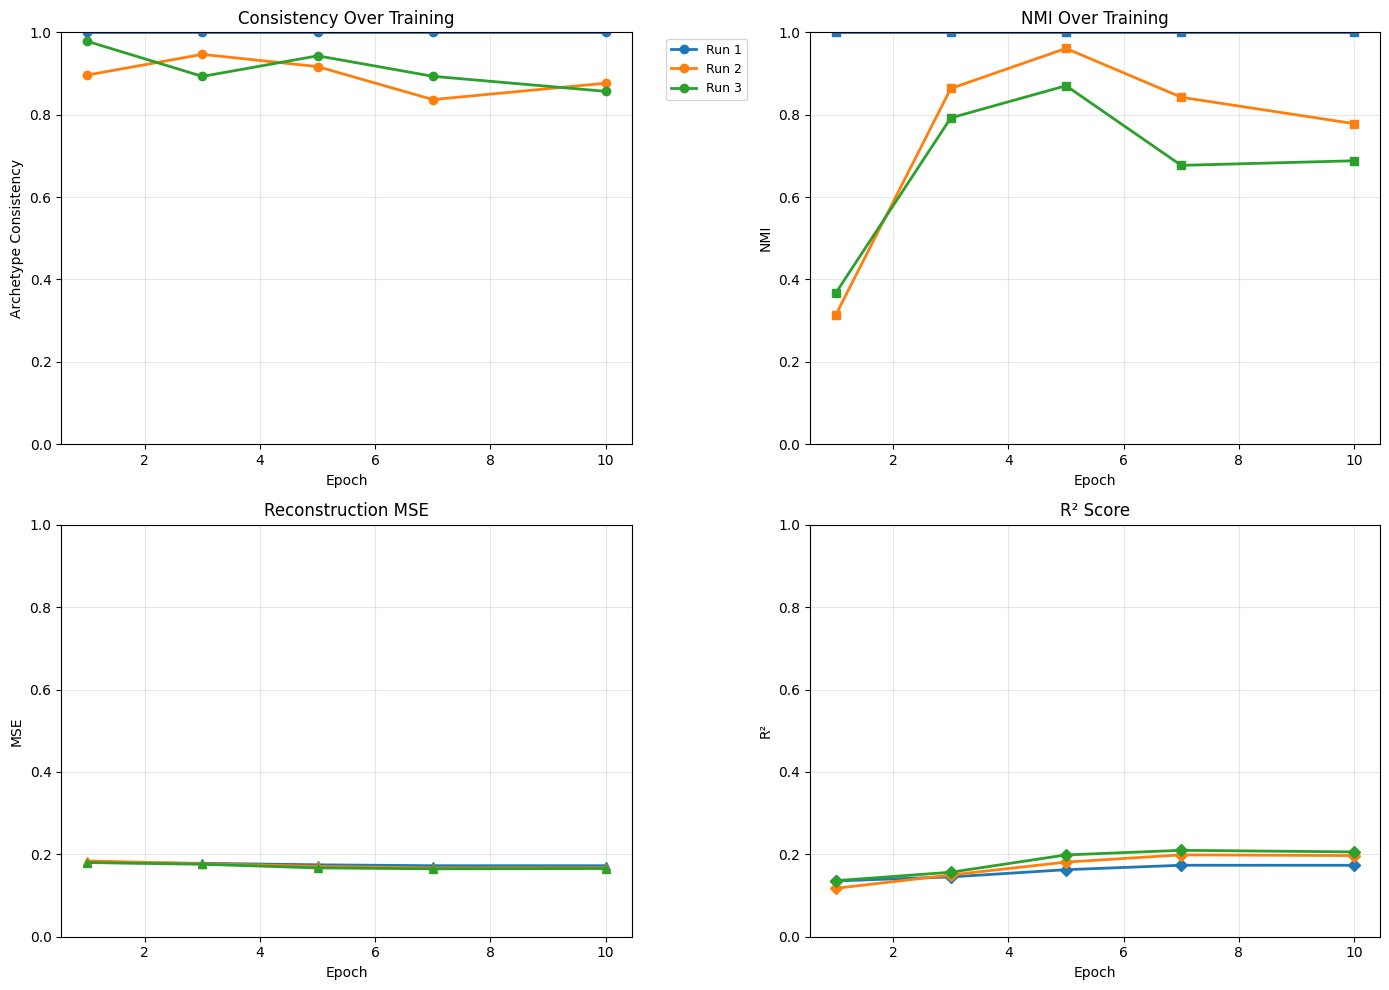

In [ ]:
# =========================================
# COMPUTE METRICS AT EACH CHECKPOINT (PER RUN)
# =========================================

print("\n📈 Computing metrics at checkpoints (per run)...")

# Initialize per-run metrics
checkpoint_metrics_per_run = {
    run: {'epoch': [], 'consistency': [], 'nmi': [], 'isi': [], 'mse': [], 'r2': []}
    for run in range(N_RUNS)
}

X_samples = X_raw.T  # shape: (N_samples, features)

for epoch in checkpoint_results.keys():
    S_list_cp = checkpoint_results[epoch]['S_list']
    C_list_cp = checkpoint_results[epoch]['C_list']
    
    for run_idx in range(N_RUNS):
        # Compare each run to first run (or any reference run)
        S_i, C_i = S_list_cp[run_idx], C_list_cp[run_idx]
        S_ref, C_ref = S_list_cp[0], C_list_cp[0]
        
        # Stability metrics
        nmi_val = calcNMI(S_i, S_ref)
        consistency_val, isi_val = ArchetypeConsistency(C_i, C_ref, mSST)
        
        # Reconstruction metrics
        X_rec_cp, _, _ = reconstruct(X_samples.T, C_i, S_i)
        metrics_cp = mse_metrics(X_samples, X_rec_cp)
        
        # Store per-run metrics
        checkpoint_metrics_per_run[run_idx]['epoch'].append(epoch)
        checkpoint_metrics_per_run[run_idx]['consistency'].append(consistency_val)
        checkpoint_metrics_per_run[run_idx]['nmi'].append(nmi_val)
        checkpoint_metrics_per_run[run_idx]['isi'].append(isi_val)
        checkpoint_metrics_per_run[run_idx]['mse'].append(metrics_cp['MSE'])
        checkpoint_metrics_per_run[run_idx]['r2'].append(metrics_cp['R2'])

# =========================================
# PLOT METRICS OVER EPOCHS (ONE LINE PER RUN)
# =========================================

print("\n📊 Plotting metrics evolution (per run)...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = plt.cm.tab10.colors  # up to 10 runs, repeat if more

for run_idx in range(N_RUNS):
    metrics = checkpoint_metrics_per_run[run_idx]
    color = colors[run_idx % len(colors)]
    
    axes[0, 0].plot(metrics['epoch'], metrics['consistency'], marker='o', linewidth=2, markersize=6, color=color, label=f'Run {run_idx+1}')
    axes[0, 1].plot(metrics['epoch'], metrics['nmi'], marker='s', linewidth=2, markersize=6, color=color, label=f'Run {run_idx+1}')
    axes[1, 0].plot(metrics['epoch'], metrics['mse'], marker='^', linewidth=2, markersize=6, color=color, label=f'Run {run_idx+1}')
    axes[1, 1].plot(metrics['epoch'], metrics['r2'], marker='D', linewidth=2, markersize=6, color=color, label=f'Run {run_idx+1}')

# Labels, titles, grid
axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Archetype Consistency'); axes[0, 0].set_title('Consistency Over Training'); axes[0, 0].grid(True, alpha=0.3); axes[0, 0].set_ylim([0,1.0])
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('NMI')
axes[0, 1].set_title('NMI Over Training')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1.0])

axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Reconstruction MSE')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.0])

axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('R²')
axes[1, 1].set_title('R² Score')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1.0])

# Optional: legend
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0,1].legend().remove()
axes[1,0].legend().remove()
axes[1,1].legend().remove()

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'metrics_evolution_per_run.png'), dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# =========================================
# SUMMARY TABLE
# =========================================

print("\n" + "="*70)
print("SUMMARY: Metrics Across Training Epochs")
print("="*70)
print(f"{'Epoch':<8} {'Consistency':<15} {'NMI':<12} {'MSE':<12} {'R²':<10}")
print("-"*70)
for i, ep in enumerate(checkpoint_metrics['epoch']):
    print(f"{ep:<8} {checkpoint_metrics['consistency'][i]:<15.6f} "
          f"{checkpoint_metrics['nmi'][i]:<12.6f} "
          f"{checkpoint_metrics['mse'][i]:<12.6f} "
          f"{checkpoint_metrics['r2'][i]:<10.6f}")
print("="*70)


SUMMARY: Metrics Across Training Epochs
Epoch    Consistency     NMI          MSE          R²        
----------------------------------------------------------------------
1        0.919847        0.341450     0.180283     0.135466  
3        0.931642        0.849680     0.178259     0.145175  
5        0.911434        0.916528     0.174595     0.162745  
7        0.843393        0.840981     0.172353     0.173496  
10       0.832594        0.837093     0.172371     0.173409  


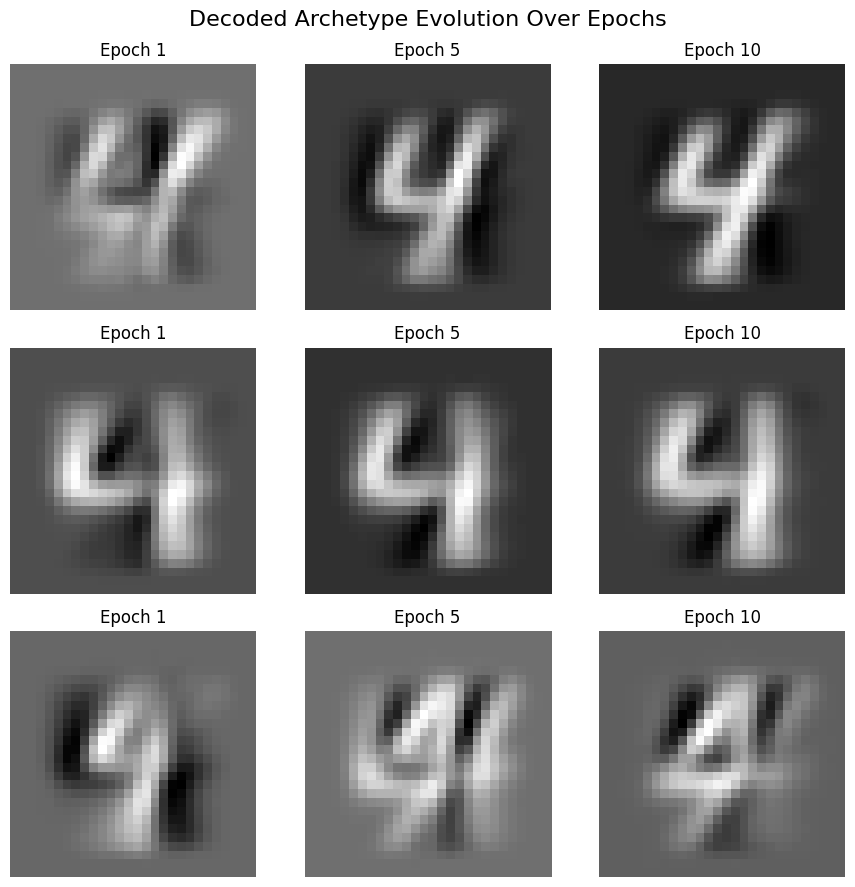

In [ ]:
# Plot the evolution of all 3 archetypes over training epochs (decoded AA)
img_shape = (28, 28)
n_archetypes = N_ARCHETYPES

# Only use epochs present in checkpoint_results
available_epochs = [ep for ep in CHECKPOINTS if ep in checkpoint_results]

# Collect decoded archetypes for each available epoch
C_pixel_list = []
for epoch in available_epochs:
    C_latent = checkpoint_results[epoch]['C_list'][0]  # (N, K) - latent space
    S = checkpoint_results[epoch]['S_list'][0]         # (K, N)
    X = X_samples.T                                     # (D, N) = (784, 5842)
    
    # Decode: C_pixel = X @ C_latent (weighted combination of data in pixel space)
    # But wait, we want C in pixel space not as combinations...
    # Actually decode properly using S
    C_decoded_epoch = compute_C_from_S(X, S)  # (D, K) = (784, K)
    C_pixel_list.append(C_decoded_epoch)

# Plot evolution for all archetypes
fig, axes = plt.subplots(n_archetypes, len(C_pixel_list), 
                         figsize=(3*len(C_pixel_list), 3*n_archetypes))

for arc_idx in range(n_archetypes):
    for i, C_pixel in enumerate(C_pixel_list):
        archetype_img = C_pixel[:, arc_idx].reshape(img_shape)
        axes[arc_idx, i].imshow(archetype_img, cmap='gray')
        axes[arc_idx, i].set_title(f'Epoch {available_epochs[i]}')
        axes[arc_idx, i].axis('off')
    axes[arc_idx, 0].set_ylabel(f'Archetype {arc_idx+1}', fontsize=12)

plt.suptitle('Decoded Archetype Evolution Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()



In [ ]:
def plot_reconstruction_flat(X_true, X_rec, n_samples=5, img_shape=(28, 28), title="Reconstruction Comparison"):
    """
    Plot original vs reconstructed images side by side (horizontal layout).
    
    Parameters:
    -----------
    X_true : array, shape (N, D)
        Original data samples.
    X_rec : array, shape (N, D)
        Reconstructed data samples.
    n_samples : int
        Number of samples to display.
    img_shape : tuple
        Shape to reshape features for display (height, width).
    """
    N = X_true.shape[0]
    indices = np.random.choice(N, n_samples, replace=False)
    
    fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 6))
    
    for i, idx in enumerate(indices):
        orig_img = X_true[idx].reshape(img_shape)
        rec_img = X_rec[idx].reshape(img_shape)
        
        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(rec_img, cmap='gray')
        axes[1, i].set_title(f"Reconstructed {i+1}")
        axes[1, i].axis("off")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Found 1334 relatively pure samples
Indices of pure samples: [ 0  1  2  5  6 13 18 20 22 30]


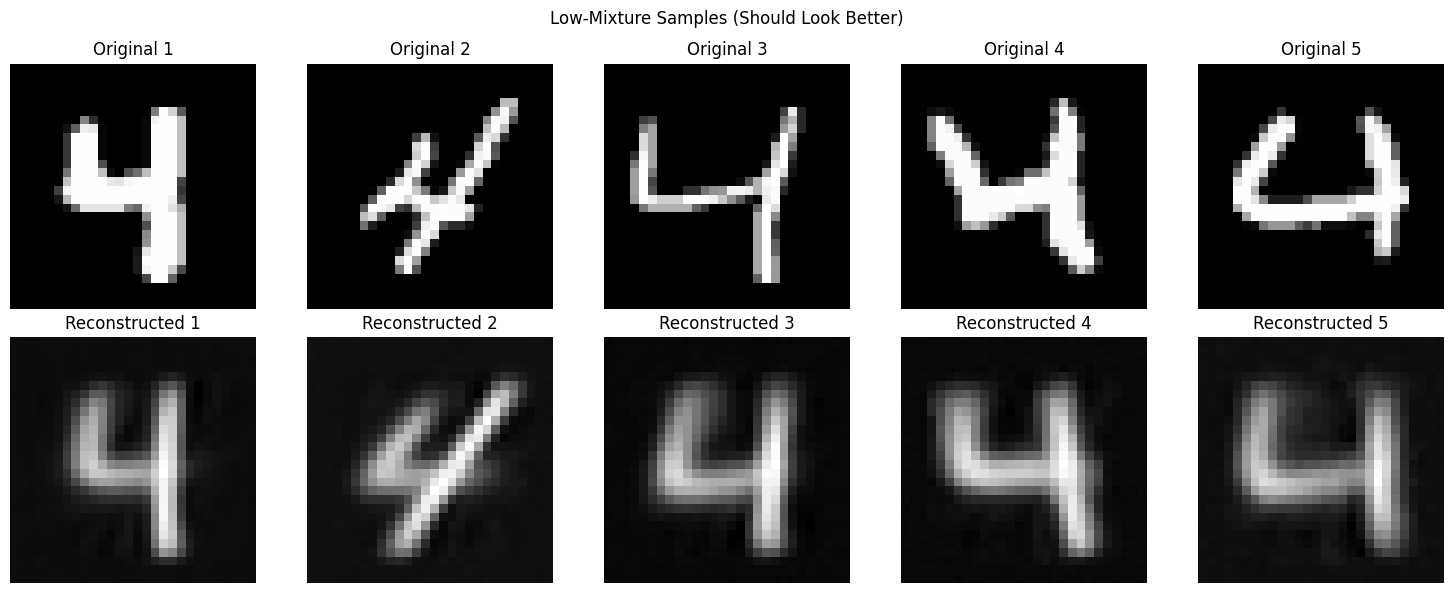

In [ ]:
from scipy.stats import entropy

# Calculate how "mixed" each sample is
mix_strength = np.array([entropy(S_matrices[0][:, i]) for i in range(S_matrices[0].shape[1])])
mix_strength /= np.log(N_ARCHETYPES)  # normalize

# Show samples with low mixing (close to pure archetypes)
pure_samples = np.where(mix_strength < 0.2)[0]
print(f"Found {len(pure_samples)} relatively pure samples")
print("Indices of pure samples:", pure_samples[:10])

plot_reconstruction_flat(X_samples[pure_samples[:5]], 
                        X_rec[pure_samples[:5]],
                        title="Low-Mixture Samples (Should Look Better)")

np.save("X_rec_AANET.npy", X_rec)


# PART 2.1: Linear AA in SC Dataset

In [ ]:
np.random.seed(0)
N_ARCHETYPES = 4
N_RUNS = 3
N_PROTOTYPES = 4 
SAVE_DIR = "results/beta_cells/LinearAA"

os.makedirs(SAVE_DIR, exist_ok=True)

### Load the dataset

In [ ]:

# 1. Load Data
print("Loading single-cell dataset...")
adata_beta_hfd = scanpy.read_h5ad('data/beta_cells_hfd.h5ad')

# show size of dataset
print(f"Dataset shape: {adata_beta_hfd.X.shape}")

adata_beta_hfd

Loading single-cell dataset...
Dataset shape: (3887, 16483)


AnnData object with n_obs × n_vars = 3887 × 16483
    obs: 'sample'
    var: 'human_name', 'ids'

### Subsample

In [ ]:
# Dataset is too big, subsample for faster testing
adata_beta_hfd = adata_beta_hfd[:1000, :]
print(f"Subsampled dataset shape: {adata_beta_hfd.X.shape}")

Subsampled dataset shape: (1000, 16483)


### Apply Magic
Result: hfd_magic → imputed gene expression matrix with fewer zeros.

In [ ]:
hfd_magic_op = magic.MAGIC(random_state=42, t=10)
hfd_magic = hfd_magic_op.fit_transform(adata_beta_hfd.to_df())

Calculating MAGIC...
  Running MAGIC on 1000 cells and 16483 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/opt/anaconda3/envs/sae_env/lib/python3.11/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.64 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.08 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.77 seconds.
  Running MAGIC with `solver='exact'` on 16483-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.49 seconds.
Calculated MAGIC in 1.34 seconds.


In [ ]:

hfd_pc_op = decomposition.PCA(n_components=20, random_state=42)
hfd_magic_pc = hfd_pc_op.fit_transform(hfd_magic)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
hfd_magic_pc_norm = scaler.fit_transform(hfd_magic_pc)  # shape (n_samples, n_components)

# Normalize for AAnet model
hfd_magic_pc_norm = hfd_magic_pc / np.std(hfd_magic_pc[:, 0])

# Print everything to debug
print(f"Magic Imputed Data Shape: {hfd_magic.shape}")
print(f"PCA Reduced Data Shape: {hfd_magic_pc.shape}")
print(f"Normalized Data Shape: {hfd_magic_pc_norm.shape}")



Magic Imputed Data Shape: (1000, 16483)
PCA Reduced Data Shape: (1000, 20)
Normalized Data Shape: (1000, 20)


### Running the Gaussian method on the cell data
Used 4 as n_archetypes because that's what we used in the AANet implementation, for comparison.

In [ ]:
S_list = []
C_list = []
L_list = []  

X = torch.tensor(hfd_magic_pc_norm, dtype=torch.float64).T

for run in range(N_RUNS):
    print(f"Run {run+1}/{N_RUNS}")
    
    C_run, S_run, L_run, EV = AALS(X, N_ARCHETYPES)  # Your Linear AA function
    
    # Append to lists
    S_list.append(S_run.detach().cpu().numpy() if isinstance(S_run, torch.Tensor) else S_run)
    C_list.append(C_run.detach().cpu().numpy() if isinstance(C_run, torch.Tensor) else C_run)
    L_list.append(L_run)

# Save everything
torch.save({'C': C_list, 'S': S_list, 'L': L_list}, os.path.join(SAVE_DIR, '/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/LinearAA/Python/results/beta_cells/LinearAA/beta_cells_gaussian_aa_results.pth'))


Run 1/3
Run 2/3
Run 3/3


## Visualize the results

In [ ]:
# Open the saved results to verify
results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/LinearAA/Python/results/beta_cells/LinearAA/beta_cells_gaussian_aa_results.pth', weights_only=False)
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C'][0].shape)
print("Shape of S in first run:", results['S'][0].shape)
print("Length of Losses in first run:", len(results['L'][0]))

Saved Results Keys: dict_keys(['C', 'S', 'L'])
Number of Runs Saved: 3
Shape of C in first run: (1000, 4)
Shape of S in first run: (4, 1000)
Length of Losses in first run: 78


## Calculating the metrics

In [ ]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [ ]:
from itertools import combinations

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C']]
print("C_matrices length:", len(C_matrices))
S_matrices = [to_numpy(S) for S in results['S']]
print("C_matrices length:", len(C_matrices))
X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Linear AA 5-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 3
C_matrices length: 3
---
Linear AA 5-run stability:
---
Mean NMI: 0.992469596215924
Mean Archetype Consistency: 0.9972863952436756
Mean ISI: 0.026598507753214238


## Analysing the Archetypes

In [ ]:
# Select archetypes to visualize from the loaded results
C_linear = results['C'][0]
S_linear = results['S'][0]

print("C_linear shape:", C_linear.shape)
print("S_linear shape:", S_linear.shape)

C_linear shape: (1000, 4)
S_linear shape: (4, 1000)


## Visualizing the Archetypes

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# After getting best run
C_linear_best = C_list[best_run_idx].copy()
S_linear_best = S_list[best_run_idx].copy()

print(f"\n{'='*60}")
print("FIXING DEGENERATE AALS SOLUTION")
print(f"{'='*60}")

# Check C
print(f"C: {(C_linear_best.sum(axis=1) < 0.01).sum()}/{C_linear_best.shape[0]} rows near zero")
# Check S  
print(f"S row sums BEFORE: {S_linear_best.sum(axis=1)}")

# FIX C: For rows that sum to ~0, assign uniform weights
zero_rows = np.abs(C_linear_best.sum(axis=1)) < 0.01
C_linear_best[zero_rows] = 1.0 / N_ARCHETYPES
print(f"Fixed {zero_rows.sum()} zero rows in C")

# FIX S: Normalize rows to sum to 1 (each archetype = convex combo of samples)
S_linear_best = S_linear_best / (S_linear_best.sum(axis=1, keepdims=True) + 1e-12)
print(f"S row sums AFTER: {S_linear_best.sum(axis=1)}")

# Now normalize both properly
C_linear_best = C_linear_best / (C_linear_best.sum(axis=1, keepdims=True) + 1e-12)

print(f"\n✓ C row sums = 1? {np.allclose(C_linear_best.sum(axis=1), 1.0)}")
print(f"✓ S row sums = 1? {np.allclose(S_linear_best.sum(axis=1), 1.0)}")
print(f"✓ Mean C weight: {C_linear_best.mean():.6f}")
print(f"{'='*60}\n")

# Get PCA data in correct shape (samples as rows)
X_pca = hfd_magic_pc  # (n_samples, n_pcs) = (1000, 20)

print(f"Original C shape: {C_linear_best.shape}")
print(f"Original S shape: {S_linear_best.shape}")
print(f"X_pca shape: {X_pca.shape}")

# Compute archetypes in PCA space
archetypes_pca = S_linear_best @ X_pca  # (4, 1000) @ (1000, 20) = (4, 20)

print(f"Archetypes in PCA space: {archetypes_pca.shape}")

# Denormalize PCA coordinates
archetypes_pca_denorm = archetypes_pca * np.std(hfd_magic_pc[:, 0])

# Transform back to gene space
data_ats_linear = (archetypes_pca_denorm @ hfd_pc_op.components_) + hfd_pc_op.mean_

print(f"Linear AA archetypes in gene space: {data_ats_linear.shape}")

# Barycentric embedding (cell weights for each archetype)
barycentric_embedding_linear = C_linear_best

print(f"Barycentric embedding: {barycentric_embedding_linear.shape}")

# Verify the decomposition makes sense
X_reconstructed = barycentric_embedding_linear @ archetypes_pca
mse = np.mean((X_pca - X_reconstructed)**2)
rmse = np.sqrt(mse)
r2 = r2_score(X_pca, X_reconstructed)

print(f"\nReconstruction Metrics:")
print(f"  MSE:  {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  R2:   {r2:.6f}")

reconstruction_error = mse

# Final verification
print(f"\n{'='*60}")
print("FINAL VERIFICATION")
print(f"{'='*60}")
print(f"S rows sum to 1: {S_linear_best.sum(axis=1)}")
print(f"C rows sum to 1 (first 5): {C_linear_best.sum(axis=1)[:5]}")

# Weight distribution check
print(f"\nWeight Distribution:")
print(f"  C min/max: {C_linear_best.min():.4f} / {C_linear_best.max():.4f}")
near_uniform = ((C_linear_best > 0.20) & (C_linear_best < 0.30)).sum()
print(f"  Near-uniform weights (0.20-0.30): {near_uniform}/{C_linear_best.size} ({100*near_uniform/C_linear_best.size:.1f}%)")
print(f"{'='*60}\n")

# Save for visualization
np.savez(os.path.join(SAVE_DIR, 'linear_aa_archetypes.npz'),
         data_ats=data_ats_linear,
         C=C_linear_best,
         S=S_linear_best,
         barycentric_embedding=barycentric_embedding_linear,
         archetypes_pca=archetypes_pca,
         reconstruction_error=reconstruction_error)

print("✓ Successfully transformed Linear AA archetypes to gene space")
print(f"✓ Saved to {SAVE_DIR}/linear_aa_archetypes.npz")


FIXING DEGENERATE AALS SOLUTION
C: 952/1000 rows near zero
S row sums BEFORE: [219.03373414 115.61369596 418.55911132 246.79345858]
Fixed 952 zero rows in C
S row sums AFTER: [1. 1. 1. 1.]

✓ C row sums = 1? True
✓ S row sums = 1? True
✓ Mean C weight: 0.250000

Original C shape: (1000, 4)
Original S shape: (4, 1000)
X_pca shape: (1000, 20)
Archetypes in PCA space: (4, 20)
Linear AA archetypes in gene space: (4, 16483)
Barycentric embedding: (1000, 4)

Reconstruction Metrics:
  MSE:  0.172893
  RMSE: 0.415805
  R2:   0.007320

FINAL VERIFICATION
S rows sum to 1: [1. 1. 1. 1.]
C rows sum to 1 (first 5): [1. 1. 1. 1. 1.]

Weight Distribution:
  C min/max: -0.0000 / 1.0000
  Near-uniform weights (0.20-0.30): 3808/4000 (95.2%)

✓ Successfully transformed Linear AA archetypes to gene space
✓ Saved to results/beta_cells/LinearAA/linear_aa_archetypes.npz


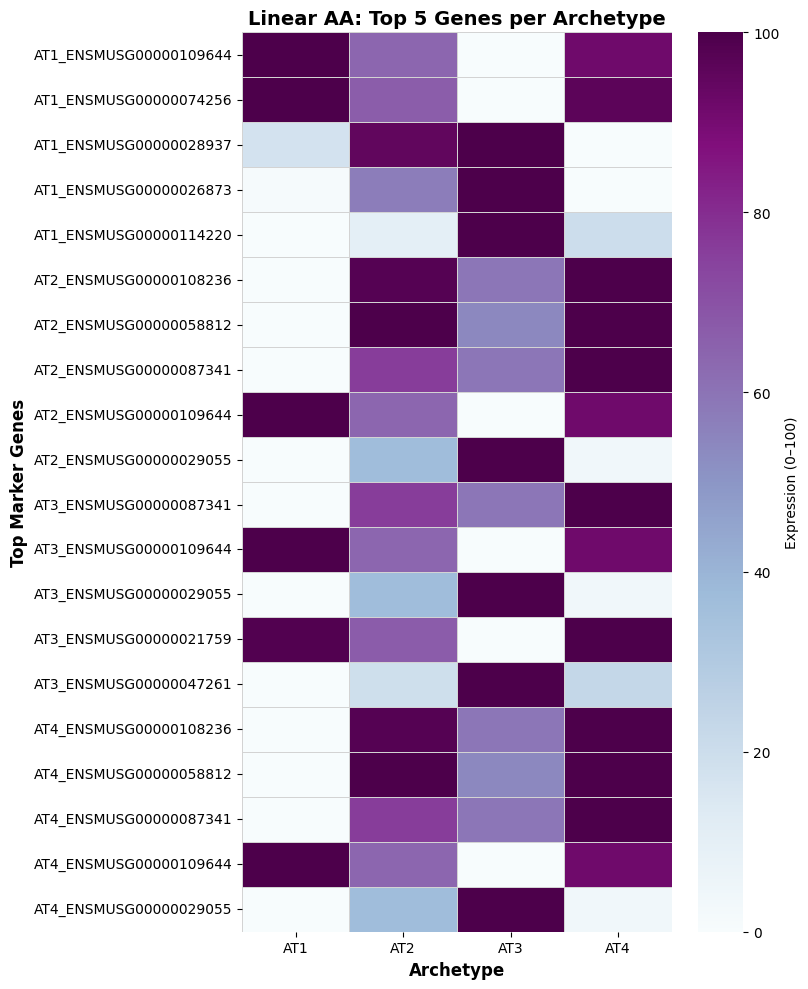


Linear AA - Top genes per archetype:

Archetype 1:
  ENSMUSG00000109644: 99.9th percentile
  ENSMUSG00000074256: 99.9th percentile
  ENSMUSG00000028937: 99.9th percentile
  ENSMUSG00000026873: 99.9th percentile
  ENSMUSG00000114220: 99.9th percentile

Archetype 2:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000058812: 100.0th percentile
  ENSMUSG00000087341: 100.0th percentile
  ENSMUSG00000109644: 99.9th percentile
  ENSMUSG00000029055: 99.9th percentile

Archetype 3:
  ENSMUSG00000087341: 100.0th percentile
  ENSMUSG00000109644: 99.9th percentile
  ENSMUSG00000029055: 99.9th percentile
  ENSMUSG00000021759: 99.9th percentile
  ENSMUSG00000047261: 99.9th percentile

Archetype 4:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000058812: 100.0th percentile
  ENSMUSG00000087341: 100.0th percentile
  ENSMUSG00000109644: 99.9th percentile
  ENSMUSG00000029055: 99.9th percentile


In [ ]:

# =============================================================================
# VISUALIZATIONS FOR LINEAR AA (0–100 SCALE)
# =============================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load full dataset for gene names
adata_beta_hfd_full = sc.read_h5ad('data/beta_cells_hfd.h5ad')
gene_names = adata_beta_hfd_full.var_names.tolist()

# Get full data
if hasattr(adata_beta_hfd_full.X, 'toarray'):
    X_full = adata_beta_hfd_full.X.toarray()
else:
    X_full = adata_beta_hfd_full.X

# --- FIGURE: Top genes per archetype (Linear AA, 0–100 scale) ---
top_k = 5
all_top_genes = []
heatmap_data = []

for i in range(N_ARCHETYPES):
    archetype_expr = data_ats_linear[i, :]
    
    # Calculate percentiles (using only the 1000 subsampled cells you trained on)
    X_subset = X_full[:1000, :]
    percentiles = np.array([(X_subset[:, j] < archetype_expr[j]).sum() / len(X_subset) * 100 
                            for j in range(len(archetype_expr))])
    
    top_indices = np.argsort(percentiles)[-top_k:][::-1]
    
    for idx in top_indices:
        gene = gene_names[idx]
        all_top_genes.append(f"AT{i+1}_{gene}")
        expr_values = [data_ats_linear[j, idx] for j in range(N_ARCHETYPES)]
        heatmap_data.append(expr_values)

# Create heatmap
heatmap_df = pd.DataFrame(heatmap_data, 
                          index=all_top_genes,
                          columns=[f'AT{i+1}' for i in range(N_ARCHETYPES)])

# Normalize per gene to 0–100
heatmap_df_norm = (heatmap_df - heatmap_df.min(axis=1).values[:, None]) / \
                  (heatmap_df.max(axis=1) - heatmap_df.min(axis=1)).values[:, None] * 100

# CLEAN GENE NAMES FOR BETTER VISUALIZATION
# REMOVE "ESNMUSG000000"
def clean_gene_name(name):
    return name.replace("ENSMUSG000000", "")

# plot with the cleaned gene names

fig, ax = plt.subplots(figsize=(8, max(10, top_k * N_ARCHETYPES * 0.4)))
sns.heatmap(heatmap_df_norm, cmap='BuPu', 
            cbar_kws={'label': 'Expression (0–100)'},
            linewidths=0.5, linecolor='lightgray',
            ax=ax, vmin=0, vmax=100, yticklabels=True)

ax.set_xlabel('Archetype', fontsize=12, fontweight='bold')
ax.set_ylabel('Top Marker Genes', fontsize=12, fontweight='bold')
ax.set_title(f'Linear AA: Top {top_k} Genes per Archetype', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig(f'{SAVE_DIR}/linear_aa_gene_signatures_0_100.png', dpi=300, bbox_inches='tight')
plt.close()

# Print top genes per archetype
print("\nLinear AA - Top genes per archetype:")
for i in range(N_ARCHETYPES):
    archetype_expr = data_ats_linear[i, :]
    X_subset = X_full[:1000, :]
    percentiles = np.array([(X_subset[:, j] < archetype_expr[j]).sum() / len(X_subset) * 100 
                            for j in range(len(archetype_expr))])
    top_indices = np.argsort(percentiles)[-top_k:][::-1]
    
    print(f"\nArchetype {i+1}:")
    for idx in top_indices:
        gene = gene_names[idx]
        print(f"  {gene}: {percentiles[idx]:.1f}th percentile")


Calculating PHATE...
  Running PHATE on 1000 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.24 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.27 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.99 seconds.
Calculated PHATE in 1.59 seconds.


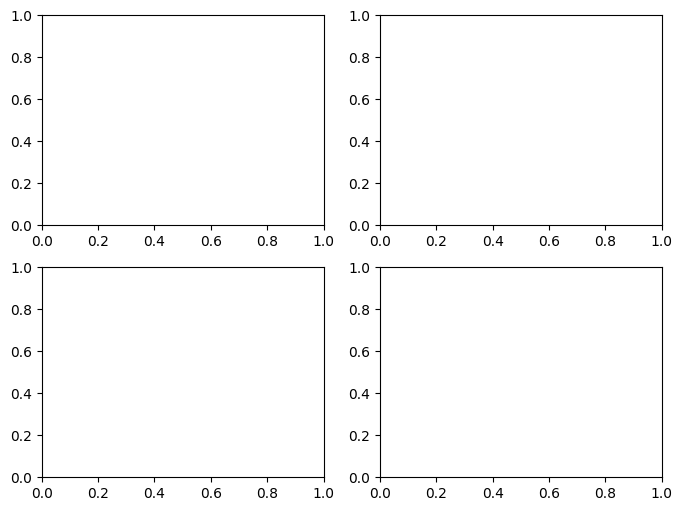

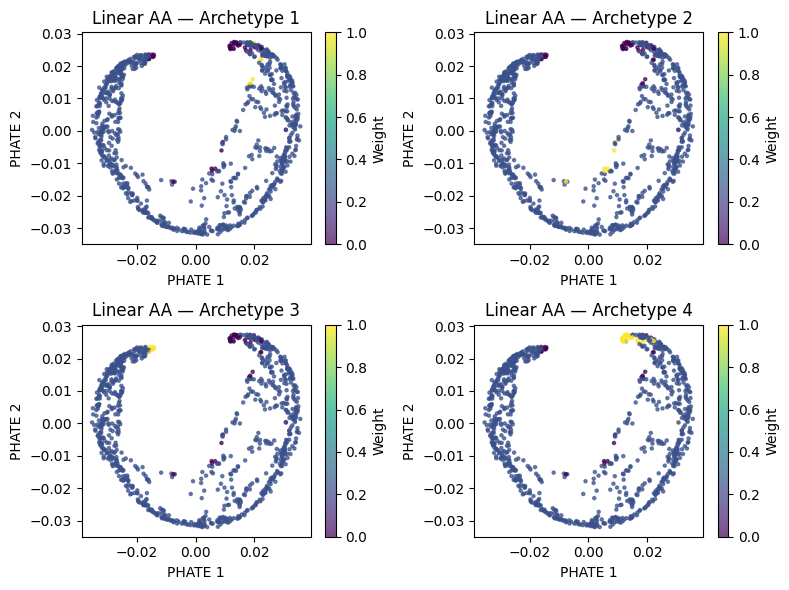

<Figure size 640x480 with 0 Axes>

In [ ]:
import phate

# Compute PHATE embedding on your 1000 × genes or 1000 × PCs dataset
phate_op = phate.PHATE(random_state=42)
data_phate_linear = phate_op.fit_transform(X_pca)  # or hfd_magic_pc_norm

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i in range(N_ARCHETYPES):
    ax = axes[i]
    sc = ax.scatter(data_phate_linear[:, 0], data_phate_linear[:, 1],
                    c=barycentric_embedding_linear[:, i],
                    cmap='viridis', s=5, alpha=0.7,
                    vmin=0, vmax=1)  # ← ADD THIS
    ax.set_title(f'Linear AA — Archetype {i+1}')
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    plt.colorbar(sc, ax=ax, label='Weight')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'phate_archetypes_linear.png'), dpi=300)
plt.show()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'phate_archetypes_linear.png'), dpi=300)
plt.show()





# PART 2.2: Deep AA (AANET) in the SC Dataset

### Global Setup

In [ ]:
np.random.seed(0)
N_ARCHETYPES = 4
N_RUNS = 3
N_EPOCHS = 15
SAVE_DIR = "results/beta_cells/AANET15Epochs"

# make sure save directory exists
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)


### Load the dataset

In [ ]:


# 1. Load Data
print("Loading single-cell dataset...")
adata_beta_hfd = scanpy.read_h5ad('data/beta_cells_hfd.h5ad')

print(f"Dataset shape: {adata_beta_hfd.X.shape}")

# Display AnnData summary
display(adata_beta_hfd)

# Show variable names and columns
#print("Variable names:", list(adata_beta_hfd.var_names))
#print("Variable columns:", list(adata_beta_hfd.var.columns))

# Convert to pandas DataFrame for easier inspection
df_beta_hfd = adata_beta_hfd.to_df()
#print("First few rows of the data:")
display(df_beta_hfd.head())


Loading single-cell dataset...
Dataset shape: (3887, 16483)


AnnData object with n_obs × n_vars = 3887 × 16483
    obs: 'sample'
    var: 'human_name', 'ids'

ENSMUSG00000109644  ENSMUSG00000007777  \
AAACCCACAATCGCGC-1_CG11-hfd                 0.0            0.000000   
AAACCCACACTGGAAG-1_CG11-hfd                 0.0            0.967189   
AAACCCACATGCAGCC-1_CG11-hfd                 0.0            0.000000   
AAACCCACATTGGGAG-1_CG11-hfd                 0.0            0.000000   
AAACCCATCTGTTCAT-1_CG11-hfd                 0.0            0.000000   

                             ENSMUSG00000024442  ENSMUSG00000042208  \
AAACCCACAATCGCGC-1_CG11-hfd                 0.0            0.000000   
AAACCCACACTGGAAG-1_CG11-hfd                 0.0            0.000000   
AAACCCACATGCAGCC-1_CG11-hfd                 0.0            0.000000   
AAACCCACATTGGGAG-1_CG11-hfd                 0.0            1.189718   
AAACCCATCTGTTCAT-1_CG11-hfd                 0.0            0.000000   

                             ENSMUSG00000020831  ENSMUSG00000107002  \
AAACCCACAATCGCGC-1_CG11-hfd            0.000000            0.000000   
AAACCCACACTGGAAG-1_CG11-hfd            0.000000            0.967189   
AAACCCACATGCAGCC-1_CG11-hfd            0.867926            0.000000   
AAACCCACATTGGGAG-1_CG11-hfd            0.000000            0.000000   
AAACCCATCTGTTCAT-1_CG11-hfd            0.000000            1.027114   

                             ENSMUSG00000046683  ENSMUSG00000058706  \
AAACCCACAATCGCGC-1_CG11-hfd                 0.0            0.000000   
AAACCCACACTGGAAG-1_CG11-hfd                 0.0            0.000000   
AAACCCACATGCAGCC-1_CG11-hfd                 0.0            0.000000   
AAACCCACATTGGGAG-1_CG11-hfd                 0.0            1.189718   
AAACCCATCTGTTCAT-1_CG11-hfd                 0.0            0.000000   

                             ENSMUSG00000108236  ENSMUSG00000028608  ...  \
AAACCCACAATCGCGC-1_CG11-hfd                 0.0                 0.0  ...   
AAACCCACACTGGAAG-1_CG11-hfd                 0.0                 0.0  ...   
AAACCCACATGCAGCC-1_CG11-hfd                 0.0                 0.0  ...   
AAACCCACATTGGGAG-1_CG11-hfd                 0.0                 0.0  ...   
AAACCCATCTGTTCAT-1_CG11-hfd                 0.0                 0.0  ...   

                             ENSMUSG00000064354  ENSMUSG00000064358  \
AAACCCACAATCGCGC-1_CG11-hfd            8.602648            8.867407   
AAACCCACACTGGAAG-1_CG11-hfd            5.721965            6.700879   
AAACCCACATGCAGCC-1_CG11-hfd            7.907183            9.895880   
AAACCCACATTGGGAG-1_CG11-hfd            7.801501            8.742604   
AAACCCATCTGTTCAT-1_CG11-hfd           11.889707           12.152979   

                             ENSMUSG00000064370  ENSMUSG00000064341  \
AAACCCACAATCGCGC-1_CG11-hfd            5.268024            3.725056   
AAACCCACACTGGAAG-1_CG11-hfd            5.639630            1.675220   
AAACCCACATGCAGCC-1_CG11-hfd            7.616020            5.420197   
AAACCCACATTGGGAG-1_CG11-hfd            7.617910            4.121303   
AAACCCATCTGTTCAT-1_CG11-hfd           10.821320            6.076489   

                             ENSMUSG00000064345  ENSMUSG00000064360  \
AAACCCACAATCGCGC-1_CG11-hfd            6.451986            3.041495   
AAACCCACACTGGAAG-1_CG11-hfd            3.618888            0.967189   
AAACCCACATGCAGCC-1_CG11-hfd            5.691372            2.125976   
AAACCCACATTGGGAG-1_CG11-hfd            5.705686            1.682515   
AAACCCATCTGTTCAT-1_CG11-hfd            7.617283            2.905118   

                             ENSMUSG00000064363  ENSMUSG00000065947  \
AAACCCACAATCGCGC-1_CG11-hfd            6.451986            2.150662   
AAACCCACACTGGAAG-1_CG11-hfd            4.215877            0.967189   
AAACCCACATGCAGCC-1_CG11-hfd            6.494964            1.735852   
AAACCCACATTGGGAG-1_CG11-hfd            3.762218            1.682515   
AAACCCATCTGTTCAT-1_CG11-hfd            8.087505            1.779014   

                             ENSMUSG00000064367  ENSMUSG00000064368  
AAACCCACAATCGCGC-1_CG11-hfd            2.150662                 0.0  
AAACCCACACTGGAAG

### Subsample

In [ ]:
# Dataset is too big, subsample for faster testing
adata_beta_hfd = adata_beta_hfd[:1000, :]
print(f"Subsampled dataset shape: {adata_beta_hfd.X.shape}")

Subsampled dataset shape: (1000, 16483)


### Apply Magic
Result: hfd_magic → imputed gene expression matrix with fewer zeros.

In [ ]:
hfd_magic_op = magic.MAGIC(random_state=42, t=10)
hfd_magic = hfd_magic_op.fit_transform(adata_beta_hfd.to_df())

Calculating MAGIC...
  Running MAGIC on 1000 cells and 16483 genes.


  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.79 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.16 seconds.
    Calculating affinities...
    Calculated affinities in 0.13 seconds.
  Calculated graph and diffusion operator in 1.10 seconds.
  Running MAGIC with `solver='exact'` on 16483-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.48 seconds.
Calculated MAGIC in 1.66 seconds.


In [ ]:
hfd_pc_op = decomposition.PCA(n_components=20, random_state=42)
hfd_magic_pc = hfd_pc_op.fit_transform(hfd_magic)

# Normalize for AAnet model
hfd_magic_pc_norm = hfd_magic_pc / np.std(hfd_magic_pc[:, 0])

# Print everything to debug
print(f"Magic Imputed Data Shape: {hfd_magic.shape}")
print(f"PCA Reduced Data Shape: {hfd_magic_pc.shape}")
print(f"Normalized Data Shape: {hfd_magic_pc_norm.shape}")

Magic Imputed Data Shape: (1000, 16483)
PCA Reduced Data Shape: (1000, 20)
Normalized Data Shape: (1000, 20)


### Run AAnet
AAnet performs much better with diffusion extrema initialization 


In [ ]:
# Added a transposoition to ensure final shape
X = torch.tensor(hfd_magic_pc_norm, dtype=torch.float64).transpose(0, 1)

extrema = torch.Tensor(utils.get_laplacian_extrema(hfd_magic_pc_norm, n_extrema=N_ARCHETYPES, subsample=False))
extrema = torch.Tensor(hfd_magic_pc_norm[extrema.numpy().astype(int)])

In [ ]:
device = torch.device('cpu')

In [ ]:
data_loader = torch.utils.data.DataLoader(hfd_magic_pc_norm, batch_size=256, shuffle=True, num_workers=2)

In [ ]:
from tqdm import trange

S_list = []
C_list = []
loss_history = []

CHECKPOINTS = [1,3,5,7,9,11,13,15]
checkpoint_results = {ep: {'S_list': [], 'C_list': []} for ep in CHECKPOINTS}

for run in range(N_RUNS):
    print(f"\n{'='*50}")
    print(f"Run {run+1}/{N_RUNS}")
    print(f"{'='*50}")
    
    model = models.AAnet_vanilla(
        noise=0.05,
        layer_widths=[256, 128],
        n_archetypes=N_ARCHETYPES,
        input_shape=hfd_magic_pc_norm.shape[1],
        device=device,
        diffusion_extrema=extrema
    )
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    run_losses = []
    
    for epoch in trange(1, N_EPOCHS + 1, desc=f"Training Run {run+1}", leave=True):
        loss, r_loss, a_loss = utils.train_epoch(model, data_loader, optimizer, epoch=epoch, gamma_extrema=1.0)
        run_losses.append(loss)
        
        if epoch % 2 == 0 or epoch == 1:
            print(f"  Epoch {epoch:2d} | Loss: {loss:.6f} | R_loss: {r_loss:.6f} | A_loss: {a_loss:.6f}")
        
        if epoch in CHECKPOINTS:
            archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm)).detach().numpy()
            barycentric_embedding = model.euclidean_to_barycentric(torch.Tensor(archetypal_embedding)).detach().numpy()
            S_T = barycentric_embedding.T
            C = S_T.T
            checkpoint_results[epoch]['S_list'].append(S_T)
            checkpoint_results[epoch]['C_list'].append(C)
    
    loss_history.append(run_losses)
    
    archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm)).detach().numpy()
    barycentric_embedding = model.euclidean_to_barycentric(torch.Tensor(archetypal_embedding)).detach().numpy()
    S_T = barycentric_embedding.T
    C = S_T.T
    S_list.append(S_T)
    C_list.append(C)
    
    print(f"\n✓ Run {run+1} complete - S shape: {S_T.shape}, C shape: {C.shape}")
    
    np.savez(os.path.join(SAVE_DIR, f'run{run+1}_results.npz'), S=S_T, C=C, X=hfd_magic_pc_norm, losses=run_losses)

torch.save({
    'S_list': S_list,
    'C_list': C_list,
    'X': hfd_magic_pc_norm,
    'loss_history': loss_history,
    'checkpoint_results': checkpoint_results
}, os.path.join(SAVE_DIR, 'AAnet_singlecell_runs.pth'))

torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'AAnet_model_last_run.pth'))

print(f"\n{'='*50}")
print(f"✅ Saved all {N_RUNS} runs results.")
print(f"{'='*50}")



📊 Plotting training curves...


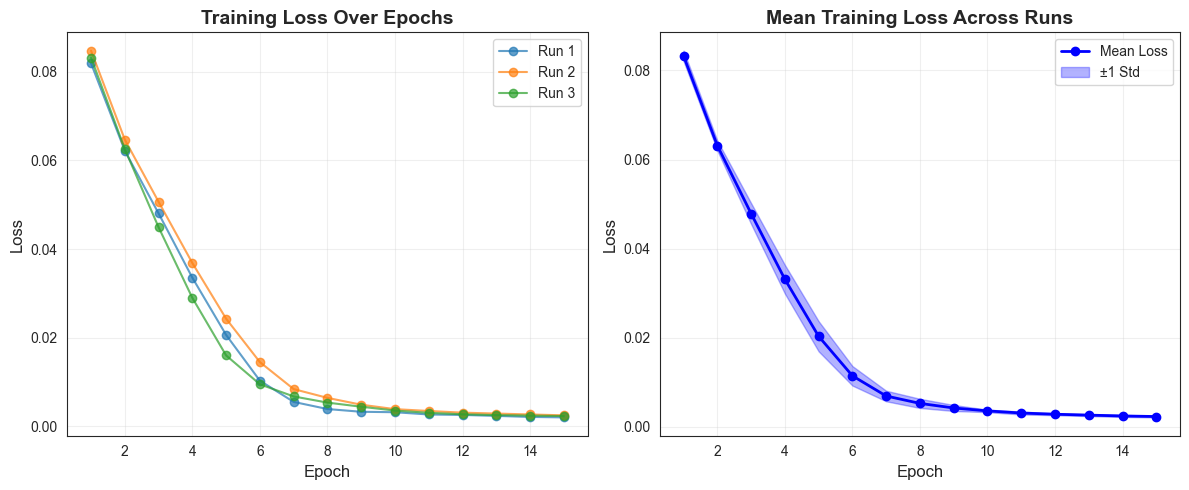

Final Loss after 15 epochs:
  Run 1: 0.002003
  Run 2: 0.002466
  Run 3: 0.002309


In [ ]:

# =========================================
# VISUALIZE TRAINING PROGRESS
# =========================================

print("\n📊 Plotting training curves...")

loss_history = results['loss_history']

# 1. Plot Loss Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, losses in enumerate(loss_history):
    plt.plot(range(1, len(losses) + 1), losses, marker='o', label=f'Run {i+1}', alpha=0.7)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Plot Average Loss ± Std
plt.subplot(1, 2, 2)
loss_array = np.array(loss_history)
mean_loss = loss_array.mean(axis=0)
std_loss = loss_array.std(axis=0)
epochs = np.arange(1, N_EPOCHS + 1)

plt.plot(epochs, mean_loss, marker='o', linewidth=2, color='blue', label='Mean Loss')
plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, 
                 alpha=0.3, color='blue', label='±1 Std')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Mean Training Loss Across Runs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_loss_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print the final loss
print(f"Final Loss after {N_EPOCHS} epochs:")
for i, losses in enumerate(loss_history):
    print(f"  Run {i+1}: {losses[-1]:.6f}")


## Visualize the Results

In [ ]:
# Open the saved results to verify
results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/beta_Cells/AANET15Epochs/AAnet_singlecell_runs.pth', weights_only=False)
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C_list']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C_list'][0].shape)
print("Shape of S in first run:", results['S_list'][0].shape)
print('Shape of X in first run:', results['X'].shape)

Saved Results Keys: dict_keys(['S_list', 'C_list', 'X', 'loss_history', 'checkpoint_results'])
Number of Runs Saved: 3
Shape of C in first run: (1000, 4)
Shape of S in first run: (4, 1000)
Shape of X in first run: (1000, 20)


## Calculating the metrics

In [ ]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [ ]:

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C_list']]
print("C_matrices length:", len(C_matrices))
print("C_matrices[0] shape:", C_matrices[0].shape)
S_matrices = [to_numpy(S) for S in results['S_list']]
print("S_matrices length:", len(S_matrices))
print("S_matrices[0] shape:", S_matrices[0].shape)

loss_histories = results['loss_history']
# Select best run based on final loss
best_run_idx = np.argmin([losses[-1] for losses in loss_histories])
C_linear_best = C_matrices[best_run_idx]  # (n_samples, n_archetypes)
S_linear_best = S_matrices[best_run_idx]  # (n_archetypes, n_samples)
print(f"Best run index: {best_run_idx}")
print(f"C_linear_best shape: {C_linear_best.shape}")
print(f"S_linear_best shape: {S_linear_best.shape}")

X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Deep AANET AA 5-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 3
C_matrices[0] shape: (1000, 4)
S_matrices length: 3
S_matrices[0] shape: (4, 1000)
Best run index: 0
C_linear_best shape: (1000, 4)
S_linear_best shape: (4, 1000)
---
Deep AANET AA 5-run stability:
---
Mean NMI: 0.9844768101880669
Mean Archetype Consistency: 0.953064908214256
Mean ISI: 0.3759222979014667


**AAnet training results in the following useful outputs:**

`barycentric_archetypal_embedding: n_obs x n_ats`: Archetypal affinity for each cell.  
`pc_ats: n_ats x n_pcs`: Embedding for each archetype based on input embedding (here we used PCs).   
`data_ats: n_ats x n_genes`: Ambient space measurement for each archetype by inverse transforming from PC space.

In [ ]:
model = models.AAnet_vanilla(
    noise=0.05,
    layer_widths=[256, 128],
    n_archetypes=N_ARCHETYPES,
    input_shape=hfd_magic_pc_norm.shape[1],
    device=device,
    diffusion_extrema=extrema
)
archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm))
print("Archetypal Embedding Shape:", archetypal_embedding.shape)
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
print("Barycentric Embedding Shape:", barycentric_archetypal_embedding.shape)
pc_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()
print("PC Archetypes Shape:", pc_ats.shape)
data_ats = ((pc_ats
             * np.std(hfd_magic_pc[:,0])) @ hfd_pc_op.components_)
print("Data Archetypes Shape:", data_ats.shape)

np.savez(os.path.join(SAVE_DIR, 'Beta_cell_AAnet_results.npz'),
         data_ats=data_ats,
         latent_coords=barycentric_archetypal_embedding)


Archetypal Embedding Shape: torch.Size([1000, 3])
Barycentric Embedding Shape: (1000, 4)
PC Archetypes Shape: (4, 20)
Data Archetypes Shape: (4, 16483)


## Analysing the Archetypes

In [ ]:
# =============================================================================
# 5. EXTRACT ARCHETYPE GENE EXPRESSIONS (from last run)
# =============================================================================
print("\n" + "="*60)
print("Extracting archetype gene expressions...")
print("="*60)

# Get archetype embeddings in PCA space
pc_ats = model.decode(
    model.get_n_simplex(model.n_archetypes).type(torch.float)
).cpu().detach().numpy()

# Transform back to gene space
# Denormalize and inverse PCA transform
import numpy as np  # Ensure numpy is imported

# Use hfd_magic_pc_norm for normalization, which is a numpy array
pc_ats_denorm = pc_ats * np.std(hfd_magic_pc_norm[:, 0])
data_ats = (pc_ats_denorm @ hfd_pc_op.components_) + hfd_pc_op.mean_

print(f"Archetype PCA embeddings shape: {pc_ats.shape}")
print(f"Archetype gene expressions shape: {data_ats.shape}")



Extracting archetype gene expressions...
Archetype PCA embeddings shape: (4, 20)
Archetype gene expressions shape: (4, 16483)


In [ ]:
# =============================================================================
# 6. COMPUTE PHATE FOR VISUALIZATION
# =============================================================================
print("\n" + "="*60)
print("Computing PHATE embedding...")
print("="*60)

X_magic = hfd_magic_pc_norm  # Use the normalized PCA data for PHATE

phate_op = phate.PHATE(n_jobs=-1, random_state=42, verbose=False)
data_phate = phate_op.fit_transform(X_magic)
print(f"PHATE embedding shape: {data_phate.shape}")

# Store in adata

adata_beta_hfd.obsm['X_phate'] = data_phate
adata_beta_hfd.obsm['X_pca_aanet'] = hfd_magic_pc_norm
adata_beta_hfd.obsm['AAnet_weights'] = barycentric_archetypal_embedding
adata_beta_hfd.uns['AAnet_archetypes_pc'] = pc_ats
adata_beta_hfd.uns['AAnet_archetypes_genes'] = data_ats

# Save annotated adata
adata_beta_hfd.write(os.path.join(SAVE_DIR, 'adata_with_aanet.h5ad'))
print(f"✓ Saved annotated AnnData")

In [ ]:
hfd_pc_op = decomposition.PCA(n_components=20, random_state=42)
hfd_magic_pc = hfd_pc_op.fit_transform(hfd_magic)

# Normalize for AAnet model
hfd_magic_pc_norm = hfd_magic_pc / np.std(hfd_magic_pc[:, 0])

# Print everything to debug
print(f"Magic Imputed Data Shape: {hfd_magic.shape}")
print(f"PCA Reduced Data Shape: {hfd_magic_pc.shape}")
print(f"Normalized Data Shape: {hfd_magic_pc_norm.shape}")

Magic Imputed Data Shape: (1000, 16483)
PCA Reduced Data Shape: (1000, 20)
Normalized Data Shape: (1000, 20)



Generating quick visualizations...
✓ Saved training overview
✓ Saved PHATE visualization

✅ COMPLETE! All results saved to: results/beta_cells/AANET

Next steps:
1. Run the Figure 8 visualization script
2. Adjust N_ARCHETYPES if needed (try 4-8)
3. Select appropriate marker genes for your dataset
Reconstruction MSE: 0.059426
Reconstruction RMSE: 0.243774
Reconstruction R2: -0.084556


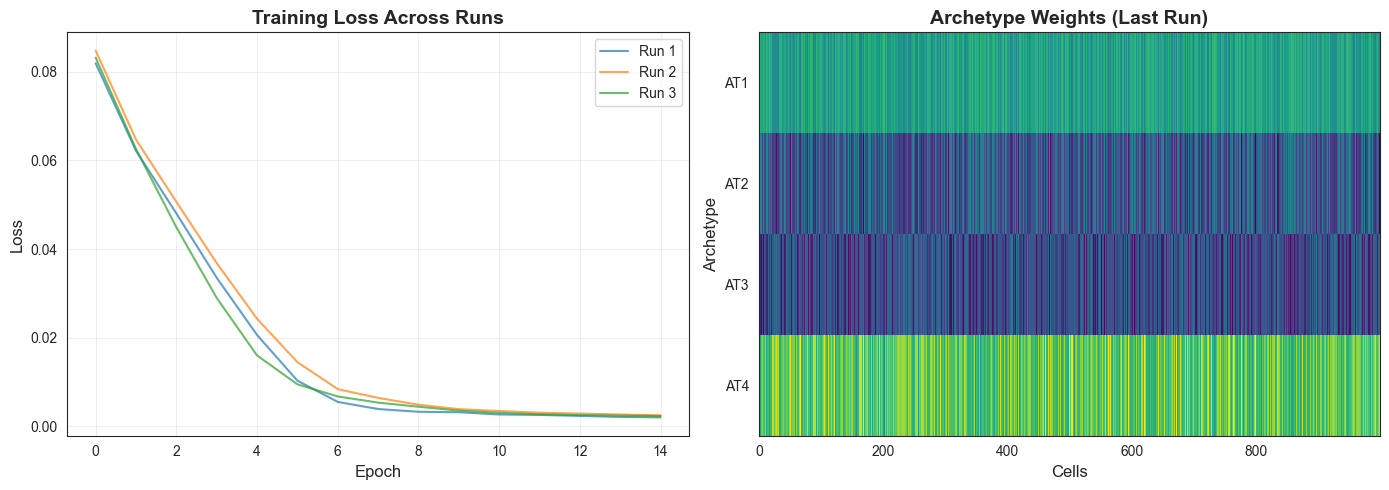

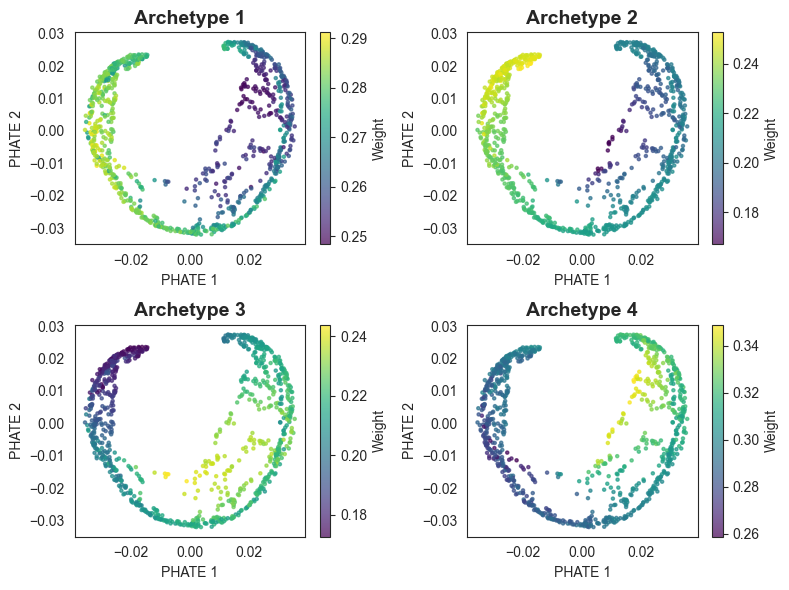

In [ ]:

print("\n" + "="*60)
print("Generating quick visualizations...")
print("="*60)

# Use loss_histories variable directly, since results['loss_history'] may not exist

loss_histories = results['loss_history']

barycentric_embedding = barycentric_archetypal_embedding

# Plot training losses
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
for run_idx, losses in enumerate(loss_histories):
    ax.plot(losses, alpha=0.7, label=f'Run {run_idx+1}')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Across Runs', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot archetype weights
ax = axes[1]
ax.imshow(barycentric_embedding.T, aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_xlabel('Cells', fontsize=12)
ax.set_ylabel('Archetype', fontsize=12)
ax.set_title('Archetype Weights (Last Run)', fontsize=14, fontweight='bold')
ax.set_yticks(range(N_ARCHETYPES))
ax.set_yticklabels([f'AT{i+1}' for i in range(N_ARCHETYPES)])

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_overview.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved training overview")

# Plot PHATE with archetype weights
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i in range(min(N_ARCHETYPES, 6)):
    ax = axes[i]
    scatter = ax.scatter(data_phate[:, 0], data_phate[:, 1],
                        c=barycentric_embedding[:, i], 
                        cmap='viridis', s=5, alpha=0.7)
    ax.set_title(f'Archetype {i+1}', fontsize=14, fontweight='bold')
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    plt.colorbar(scatter, ax=ax, label='Weight')

for i in range(N_ARCHETYPES, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'phate_archetypes.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved PHATE visualization")

print("\n" + "="*60)
print("✅ COMPLETE! All results saved to:", SAVE_DIR)
print("="*60)
print("\nNext steps:")
print("1. Run the Figure 8 visualization script")
print("2. Adjust N_ARCHETYPES if needed (try 4-8)")
print("3. Select appropriate marker genes for your dataset")
print("="*60)

# Reconstruction metrics: MSE, RMSE, R2
X_recon = model.decode(model.encode(torch.Tensor(hfd_magic_pc_norm))).detach().numpy()

mse_recon = np.mean((X_recon - hfd_magic_pc_norm) ** 2)
rmse_recon = np.sqrt(mse_recon)
ss_res = np.sum((hfd_magic_pc_norm - X_recon) ** 2)
ss_tot = np.sum((hfd_magic_pc_norm - np.mean(hfd_magic_pc_norm)) ** 2)
r2_recon = 1 - ss_res / ss_tot

print(f"Reconstruction MSE: {mse_recon:.6f}")
print(f"Reconstruction RMSE: {rmse_recon:.6f}")
print(f"Reconstruction R2: {r2_recon:.6f}")

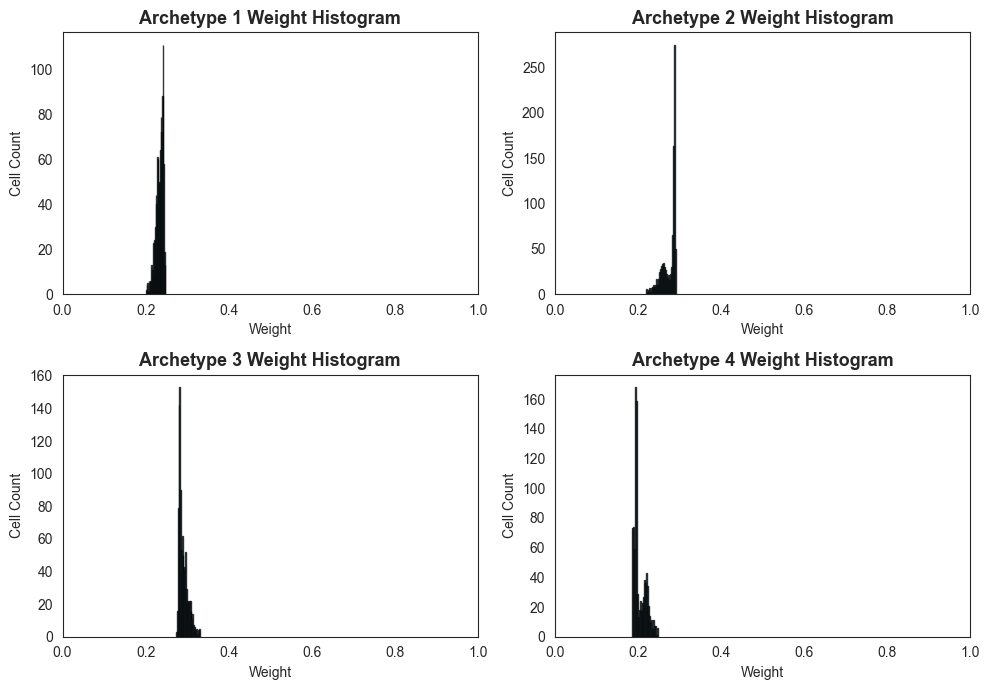

✓ Saved archetype weight histograms


<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot histogram of archetype weights for each archetype
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()
for i in range(N_ARCHETYPES):
    ax = axes[i]
    ax.hist(barycentric_embedding[:, i], bins=30, color='skyblue', edgecolor='black', alpha=0.8)
    ax.set_title(f'Archetype {i+1} Weight Histogram', fontsize=13, fontweight='bold')
    ax.set_xlabel('Weight')
    ax.set_ylabel('Cell Count')
    ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(SAVE_DIR, 'archetype_weight_histograms.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved archetype weight histograms")


Loading data and results...
Original dataset shape: (3887, 16483)
Archetypes shape: (4, 16483)
Barycentric embedding shape: (1000, 4)

Calculating PHATE embedding on full dataset...
Calculating PHATE...
  Running PHATE on 3887 observations and 16483 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.27 seconds.
    Calculating affinities...
    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 3.99 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.23 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.32 seconds.
  Calculated landmark operator in 3.55 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 1.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.59 seconds.
  Calculating metric MDS...
    SG

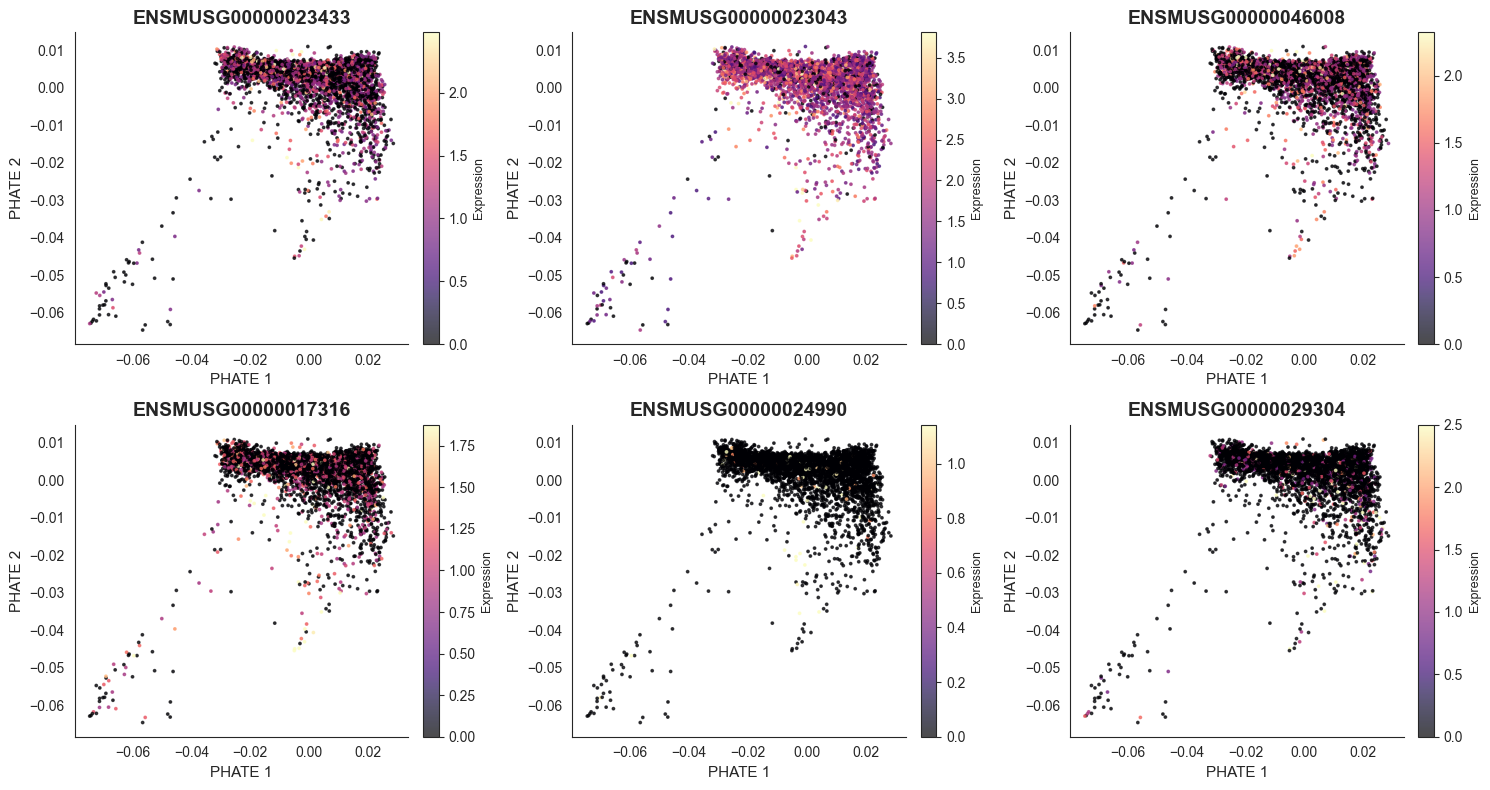

✓ Saved Figure 8a

Creating Figure 8b: Archetype gene signatures (scale 0-100)...


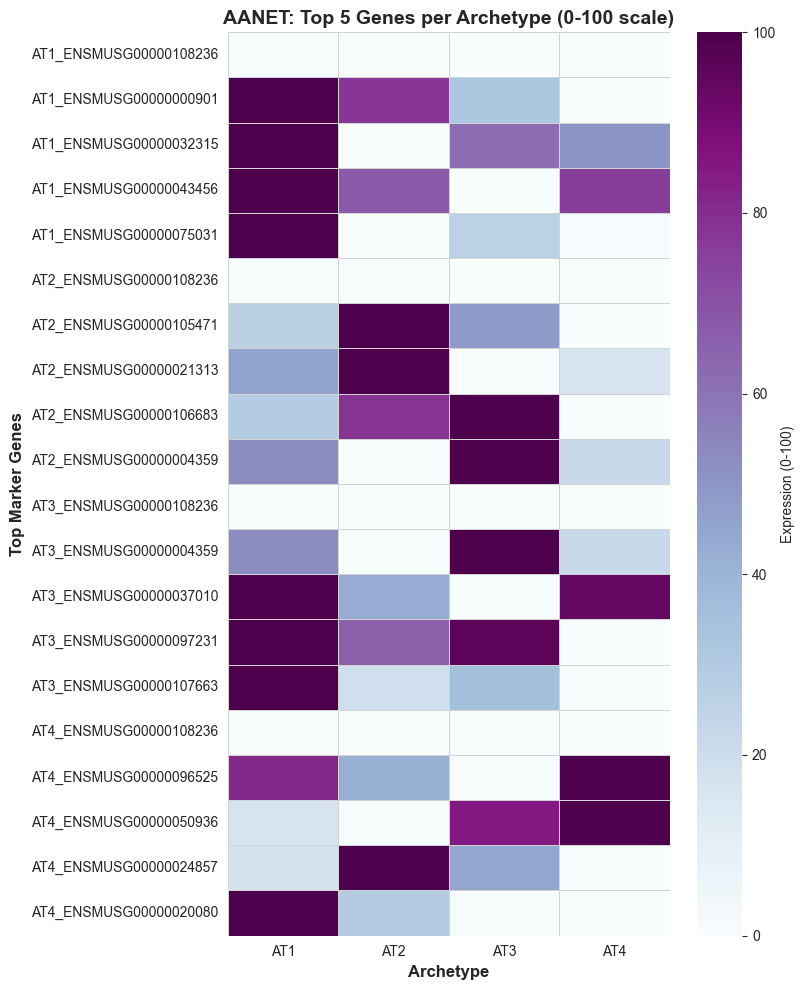

✓ Saved Figure 8b

Top genes per archetype (percentile):

Archetype 1:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000000901: 100.0th percentile
  ENSMUSG00000032315: 100.0th percentile
  ENSMUSG00000043456: 100.0th percentile
  ENSMUSG00000075031: 100.0th percentile

Archetype 2:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000105471: 100.0th percentile
  ENSMUSG00000021313: 100.0th percentile
  ENSMUSG00000106683: 100.0th percentile
  ENSMUSG00000004359: 100.0th percentile

Archetype 3:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000004359: 100.0th percentile
  ENSMUSG00000037010: 100.0th percentile
  ENSMUSG00000097231: 100.0th percentile
  ENSMUSG00000107663: 100.0th percentile

Archetype 4:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000096525: 100.0th percentile
  ENSMUSG00000050936: 100.0th percentile
  ENSMUSG00000024857: 100.0th percentile
  ENSMUSG00000020080: 100.0th percentile

Creating bonus figure: Archetype weights on PHATE...
Note: Using f

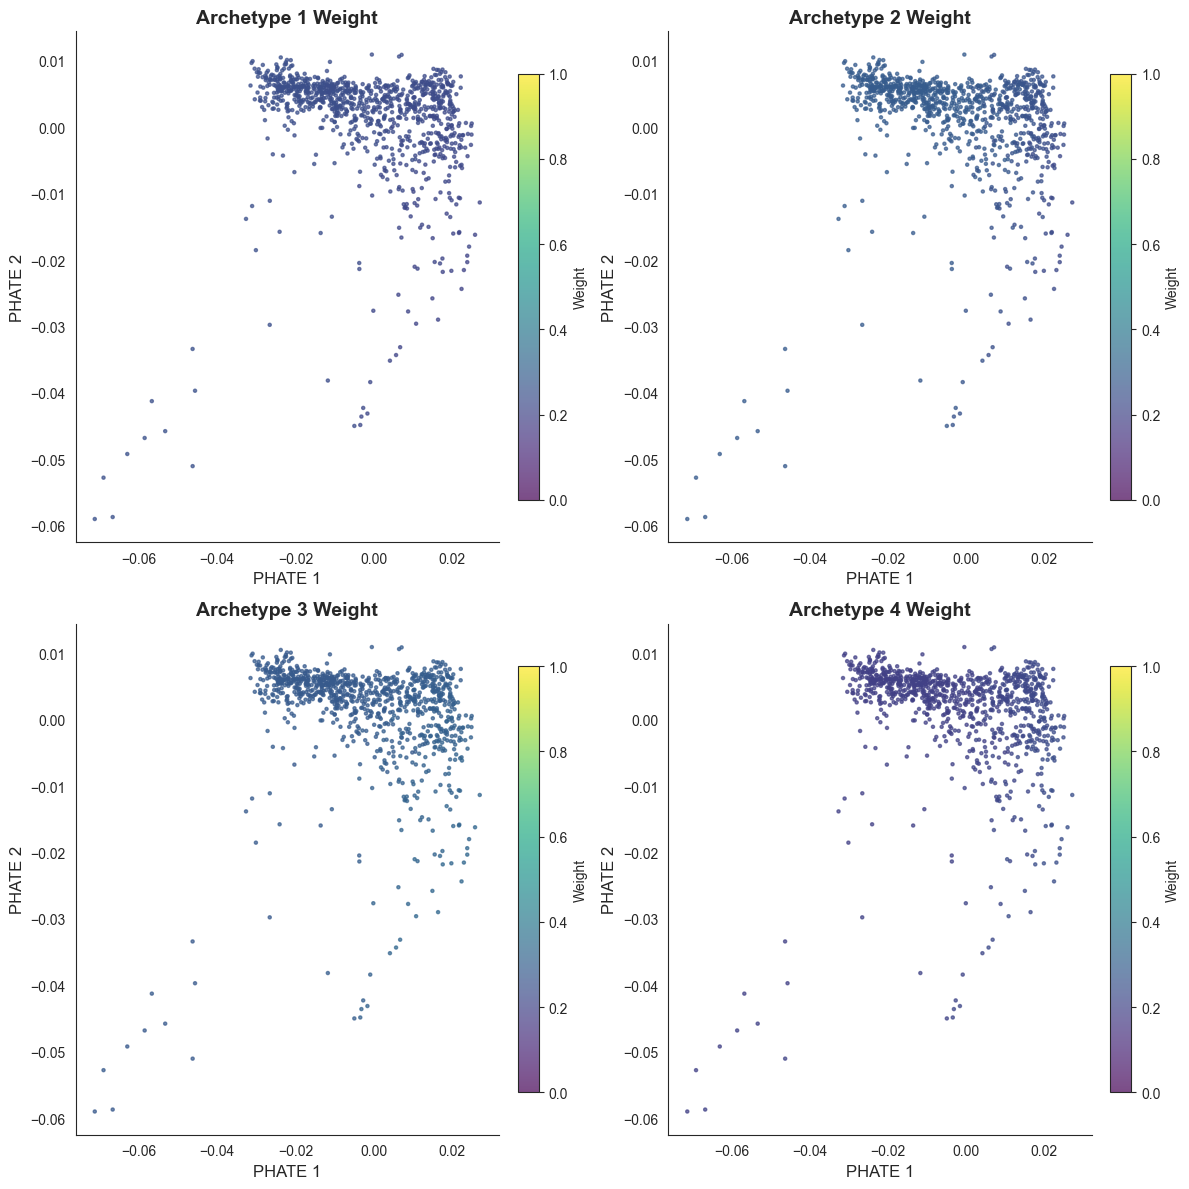

✓ Saved archetype weights on PHATE

All Figure 8 visualizations complete!
Results saved to: results/beta_cells/AANET


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import phate
import torch
from scipy.spatial.distance import cdist
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set style
sns.set_style('white')
plt.rcParams['font.size'] = 10

# =============================================================================
# LOAD EXISTING RESULTS
print("Loading data and results...")

# Load original dataset
adata_beta_hfd = sc.read_h5ad('data/beta_cells_hfd.h5ad')
print(f"Original dataset shape: {adata_beta_hfd.X.shape}")

# Load your saved AAnet results (PyTorch checkpoint)
results_path = 'results/beta_cells/AANET/AAnet_singlecell_runs.pth'
results = torch.load(results_path, weights_only=False)

# Load the saved model outputs (archetypes and barycentric embedding)
saved_results = np.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/beta_Cells/AANET15Epochs/Beta_cell_AAnet_results.npz')
data_ats = saved_results['data_ats']  # Archetype gene expressions
barycentric_embedding = saved_results['latent_coords']  # Cell weights

print(f"Archetypes shape: {data_ats.shape}")
print(f"Barycentric embedding shape: {barycentric_embedding.shape}")

# Get the last run's C matrix for consistency
C_last = results['C_list'][-1]  # Shape: (samples, archetypes)
S_last = results['S_list'][-1]  # Shape: (archetypes, samples)
X_pca = results['X']  # PCA-transformed data

N_ARCHETYPES = data_ats.shape[0]
SAVE_DIR = "results/beta_cells/AANET"

# =============================================================================
# PHATE ON FULL DATASET

print("\nCalculating PHATE embedding on full dataset...")
phate_op = phate.PHATE(n_jobs=-1, random_state=42)

# Apply PHATE to the original data (or magic-imputed if you prefer)
if hasattr(adata_beta_hfd.X, 'toarray'):
    X_full = adata_beta_hfd.X.toarray()
else:
    X_full = adata_beta_hfd.X

data_phate_full = phate_op.fit_transform(X_full)

# =============================================================================
# PHATE with marker gene expression

print("\nCreating Figure 8a: PHATE with marker genes...")

marker_genes=[]

if len(marker_genes) == 0:
    print("Warning: No marker genes found. Using top variable genes instead.")
    sc.pp.highly_variable_genes(adata_beta_hfd, n_top_genes=6)
    marker_genes = adata_beta_hfd.var_names[adata_beta_hfd.var['highly_variable']][:6].tolist()

print(f"Using marker genes: {marker_genes}")

n_markers = len(marker_genes)
n_cols = 3
n_rows = (n_markers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for idx, gene in enumerate(marker_genes):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    
    # Get gene expression
    gene_idx = adata_beta_hfd.var_names.tolist().index(gene)
    if hasattr(adata_beta_hfd.X, 'toarray'):
        expr = adata_beta_hfd.X[:, gene_idx].toarray().flatten()
    else:
        expr = adata_beta_hfd.X[:, gene_idx]
    
    # Plot
    scatter = ax.scatter(data_phate_full[:, 0], data_phate_full[:, 1],
                        c=expr, cmap='magma', s=3, alpha=0.7,
                        vmin=np.percentile(expr, 1),
                        vmax=np.percentile(expr, 99))
    
    ax.set_title(f'{gene}', fontsize=14, fontweight='bold')
    ax.set_xlabel('PHATE 1', fontsize=11)
    ax.set_ylabel('PHATE 2', fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Expression', fontsize=9)

# Remove extra subplots
for idx in range(n_markers, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()
plt.savefig(f'{SAVE_DIR}/fig8a_phate_markers.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{SAVE_DIR}/fig8a_phate_markers.pdf', bbox_inches='tight')
print(f"✓ Saved Figure 8a")
plt.close()

# =============================================================================
# Top 5 marker genes for each archetype (scale 0-100)

print("\nCreating Figure 8b: Archetype gene signatures (scale 0-100)...")

gene_names = adata_beta_hfd.var_names.tolist()
top_k = 5

all_top_genes = []
heatmap_data = []

for i in range(N_ARCHETYPES):
    archetype_expr = data_ats[i, :]
    percentiles = np.array([(X_full[:, j] < archetype_expr[j]).sum() / len(X_full) * 100 
                           for j in range(len(archetype_expr))])
    top_indices = np.argsort(percentiles)[-top_k:][::-1]
    for rank, idx in enumerate(top_indices):
        gene = gene_names[idx]
        all_top_genes.append(f"AT{i+1}_{gene}")
        expr_values = [data_ats[j, idx] for j in range(N_ARCHETYPES)]
        heatmap_data.append(expr_values)

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data, 
                         index=all_top_genes,
                         columns=[f'AT{i+1}' for i in range(N_ARCHETYPES)])

# Normalize to 0-100 scale per row
min_vals = heatmap_df.min(axis=1)
max_vals = heatmap_df.max(axis=1)
heatmap_df_norm = (heatmap_df.sub(min_vals, axis=0)
                   .div(max_vals - min_vals + 1e-10, axis=0)
                   .mul(100))

fig, ax = plt.subplots(figsize=(8, max(10, top_k * N_ARCHETYPES * 0.4)))
sns.heatmap(heatmap_df_norm, cmap='BuPu', center=50, 
            cbar_kws={'label': 'Expression (0-100)'},
            linewidths=0.5, linecolor='lightgray',
            ax=ax, vmin=0, vmax=100, yticklabels=True)
ax.set_xlabel('Archetype', fontsize=12, fontweight='bold')
ax.set_ylabel('Top Marker Genes', fontsize=12, fontweight='bold')
ax.set_title(f'AANET: Top {top_k} Genes per Archetype (0-100 scale)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()  
plt.savefig(f'{SAVE_DIR}/fig8b_gene_signatures.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{SAVE_DIR}/fig8b_gene_signatures.pdf', bbox_inches='tight')
print(f"✓ Saved Figure 8b")
plt.close()

print("\nTop genes per archetype (percentile):")
for i in range(N_ARCHETYPES):
    archetype_expr = data_ats[i, :]
    percentiles = np.array([(X_full[:, j] < archetype_expr[j]).sum() / len(X_full) * 100 
                           for j in range(len(archetype_expr))])
    top_indices = np.argsort(percentiles)[-top_k:][::-1]
    print(f"\nArchetype {i+1}:")
    for idx in top_indices:
        gene = gene_names[idx]
        print(f"  {gene}: {percentiles[idx]:.1f}th percentile")


# =============================================================================
# Archetype weights on PHATE
print("\nCreating bonus figure: Archetype weights on PHATE...")

# Note: barycentric_embedding is from subsampled data (1000 cells)
# We need to match this to the full PHATE embedding
if barycentric_embedding.shape[0] == adata_beta_hfd.shape[0]:
    weights = barycentric_embedding
    phate_coords = data_phate_full
else:
    # If using subsampled data, compute PHATE on that subset
    print(f"Note: Using first {barycentric_embedding.shape[0]} cells for weight visualization")
    weights = barycentric_embedding
    phate_coords = data_phate_full[:barycentric_embedding.shape[0], :]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i in range(min(N_ARCHETYPES, 6)):
    ax = axes[i]
    
    scatter = ax.scatter(phate_coords[:, 0], phate_coords[:, 1],
                        c=weights[:, i], cmap='viridis',
                        s=5, alpha=0.7, vmin=0, vmax=1)
    
    ax.set_title(f'Archetype {i+1} Weight', fontsize=14, fontweight='bold')
    ax.set_xlabel('PHATE 1', fontsize=12)
    ax.set_ylabel('PHATE 2', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Weight', fontsize=10)

# Remove extra subplots
for i in range(N_ARCHETYPES, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
plt.savefig(f'{SAVE_DIR}/archetype_weights_phate.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{SAVE_DIR}/archetype_weights_phate.pdf', bbox_inches='tight')
print(f"✓ Saved archetype weights on PHATE")
plt.close()

print("\n" + "="*60)
print("All Figure 8 visualizations complete!")
print(f"Results saved to: {SAVE_DIR}")
print("="*60)